In [1]:
#%% Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from networkx import DiGraph
import networkx as nx
import statistics
from itertools import permutations
from itertools import combinations #no longer being used
from IPython import display

In [2]:
curated = pd.read_csv('curated_gene_disease_associations.tsv', sep = "\t")
curated

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.700,0.538,C0019209,Hepatomegaly,phenotype,C23;C06,Finding,0.30,1.000,2017.0,2017.0,1,0,CTD_human
1,1,A1BG,0.700,0.538,C0036341,Schizophrenia,disease,F03,Mental or Behavioral Dysfunction,0.30,1.000,2015.0,2015.0,1,0,CTD_human
2,2,A2M,0.529,0.769,C0002395,Alzheimer's Disease,disease,C10;F03,Disease or Syndrome,0.50,0.769,1998.0,2018.0,3,0,CTD_human
3,2,A2M,0.529,0.769,C0007102,Malignant tumor of colon,disease,C06;C04,Neoplastic Process,0.31,1.000,2004.0,2019.0,1,0,CTD_human
4,2,A2M,0.529,0.769,C0009375,Colonic Neoplasms,group,C06;C04,Neoplastic Process,0.30,1.000,2004.0,2004.0,1,0,CTD_human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84033,109580095,HBB-LCR,0.743,0.115,C0002875,Cooley's anemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84034,109580095,HBB-LCR,0.743,0.115,C0005283,beta Thalassemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84035,109580095,HBB-LCR,0.743,0.115,C0019025,Hemoglobin F Disease,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84036,109580095,HBB-LCR,0.743,0.115,C0085578,Thalassemia Minor,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human


In [3]:
threeCol = curated.drop(columns = ['diseaseType', 'DSI', 'DPI', 'diseaseClass', 'diseaseSemanticType', 'score', 'EI', 'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps'])
threeCol

,geneId,geneSymbol,diseaseId,diseaseName,source
0,1,A1BG,C0019209,Hepatomegaly,CTD_human
1,1,A1BG,C0036341,Schizophrenia,CTD_human
2,2,A2M,C0002395,Alzheimer's Disease,CTD_human
3,2,A2M,C0007102,Malignant tumor of colon,CTD_human
4,2,A2M,C0009375,Colonic Neoplasms,CTD_human
...,...,...,...,...,...
84033,109580095,HBB-LCR,C0002875,Cooley's anemia,CTD_human
84034,109580095,HBB-LCR,C0005283,beta Thalassemia,CTD_human
84035,109580095,HBB-LCR,C0019025,Hemoglobin F Disease,CTD_human
84036,109580095,HBB-LCR,C0085578,Thalassemia Minor,CTD_human


In [5]:
threeCol['source'] = threeCol['source'].apply(lambda x: set(x[:].split(";")))
threeColsep = pd.DataFrame([(c, tup.geneId, tup.geneSymbol, tup.diseaseId, tup.diseaseName) for tup in threeCol.itertuples() for c in tup.source])
threeColsep = threeColsep.rename(columns= {0: 'source', 1: 'geneId', 2: 'geneSymbol', 3: 'diseaseId', 4: 'diseaseName'})
threeColsep

,source,geneId,geneSymbol,diseaseId,diseaseName
0,CTD_human,1,A1BG,C0019209,Hepatomegaly
1,CTD_human,1,A1BG,C0036341,Schizophrenia
2,CTD_human,2,A2M,C0002395,Alzheimer's Disease
3,CTD_human,2,A2M,C0007102,Malignant tumor of colon
4,CTD_human,2,A2M,C0009375,Colonic Neoplasms
...,...,...,...,...,...
96920,CTD_human,109580095,HBB-LCR,C0002875,Cooley's anemia
96921,CTD_human,109580095,HBB-LCR,C0005283,beta Thalassemia
96922,CTD_human,109580095,HBB-LCR,C0019025,Hemoglobin F Disease
96923,CTD_human,109580095,HBB-LCR,C0085578,Thalassemia Minor


In [7]:
diseasemappings = pd.read_csv('disease_mappings.tsv', sep = '\t')
diseasemappings

,diseaseId,name,vocabulary,code,vocabularyName
0,C0018923,Hemangiosarcoma,DO,0001816,angiosarcoma
1,C0854893,Angiosarcoma non-metastatic,DO,0001816,angiosarcoma
2,C0033999,Pterygium,DO,0002116,pterygium
3,C0025517,Metabolic Diseases,DO,0014667,disease of metabolism
4,C0155862,Streptococcal pneumonia,DO,0040084,Streptococcus pneumonia
...,...,...,...,...,...
242884,C0279628,Adenocarcinoma Of Esophagus,ORDO,99976,Adenocarcinoma of the esophagus
242885,C0279626,Squamous cell carcinoma of esophagus,ORDO,99977,Squamous cell carcinoma of the esophagus
242886,C0206702,Klatskin Tumor,ORDO,99978,Klatskin tumor
242887,C0007462,Causalgia,ORDO,99994,Complex regional pain syndrome type 2


In [8]:
diseasemappings = diseasemappings.drop(columns = ['vocabularyName'])
diseasemappings = diseasemappings.rename(columns = {'name': 'diseaseName'})
diseasemappings

,diseaseId,diseaseName,vocabulary,code
0,C0018923,Hemangiosarcoma,DO,0001816
1,C0854893,Angiosarcoma non-metastatic,DO,0001816
2,C0033999,Pterygium,DO,0002116
3,C0025517,Metabolic Diseases,DO,0014667
4,C0155862,Streptococcal pneumonia,DO,0040084
...,...,...,...,...
242884,C0279628,Adenocarcinoma Of Esophagus,ORDO,99976
242885,C0279626,Squamous cell carcinoma of esophagus,ORDO,99977
242886,C0206702,Klatskin Tumor,ORDO,99978
242887,C0007462,Causalgia,ORDO,99994


In [9]:
result1 = diseasemappings.merge(threeColsep)
result2 = result1[result1['vocabulary'].map(lambda d: d == 'DO')]
result2['DOID'] = ('DOID:' + (result2['code']))
result2

<ipython-input-9-ecb85bb04ea3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result2['DOID'] = ('DOID:' + (result2['code']))


,diseaseId,diseaseName,vocabulary,code,source,geneId,geneSymbol,DOID
0,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,285,ANGPT2,DOID:0001816
1,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,595,CCND1,DOID:0001816
2,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1440,CSF3,DOID:0001816
3,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1499,CTNNB1,DOID:0001816
4,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,2321,FLT1,DOID:0001816
...,...,...,...,...,...,...,...,...
3230992,C0020615,Hypoglycemia,DO,9993,CTD_human,5465,PPARA,DOID:9993
3230993,C0020615,Hypoglycemia,DO,9993,CTD_human,6648,SOD2,DOID:9993
3230994,C0020615,Hypoglycemia,DO,9993,CTD_human,6927,HNF1A,DOID:9993
3230995,C0020615,Hypoglycemia,DO,9993,CTD_human,7124,TNF,DOID:9993


In [10]:
resultDOID = result2.groupby(by = ['DOID', 'diseaseName', 'source'])['geneId'].apply(lambda x: set(x))
resultDOID = resultDOID.reset_index()
resultDOID

,DOID,diseaseName,source,geneId
0,DOID:0001816,Hemangiosarcoma,CGI,"{5335, 5787, 3845, 3791}"
1,DOID:0001816,Hemangiosarcoma,CTD_human,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372..."
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
4,DOID:0014667,Metabolic Diseases,CTD_human,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [15]:
resultDOID.loc[resultDOID['DOID'] == 'DOID:863']

,DOID,diseaseName,source,geneId
19310,DOID:863,nervous system disorder,CTD_human,"{7298, 6531, 1806, 6414, 1558, 1559, 4760, 103..."


In [9]:
#resultDOID.loc[resultDOID['DOID']=='DOID:9252']
#resultDOID[resultDOID['diseaseName'].str.contains('Nervous')]
#isinstance(dfcombsep.iloc[0]['propagatedDOID'], str)

In [11]:
from ontology import Ontology

In [12]:
disease_ontology = Ontology()
disease_ontology.load("/mnt/research/compbio/krishnanlab/data/ontologies/doid.obo")

In [13]:
cardio = disease_ontology.descendants('DOID:1287')
endo = disease_ontology.descendants('DOID:28')
gastro = disease_ontology.descendants('DOID:77')
hemat = disease_ontology.descendants('DOID:74')
immune = disease_ontology.descendants('DOID:2914')
integu = disease_ontology.descendants('DOID:16')
musc = disease_ontology.descendants('DOID:17')
nervous = disease_ontology.descendants('DOID:863')
reprod = disease_ontology.descendants('DOID:229')
respir = disease_ontology.descendants('DOID:1579')
thoracic = disease_ontology.descendants('DOID:0060118')
urinary = disease_ontology.descendants('DOID:18')
metabolism = disease_ontology.descendants('DOID:0014667')
mhealth = disease_ontology.descendants('DOID:150')

desired = set().union(cardio).union(endo).union(gastro).union(hemat).union(immune).union(integu).union(musc).union(nervous).union(reprod).union(respir).union(thoracic).union(urinary).union(metabolism).union(mhealth)
#desired = cardio + endo + gastro + hemat + immune + integu + musc + nervous + reprod + respir + thoracic + urinary

In [14]:
desired

{'DOID:4562',
 'DOID:9279',
 'DOID:11574',
 'DOID:5529',
 'DOID:8802',
 'DOID:5893',
 'DOID:0080118',
 'DOID:4267',
 'DOID:0060336',
 'DOID:12259',
 'DOID:0110759',
 'DOID:0110728',
 'DOID:3614',
 'DOID:14276',
 'DOID:0070127',
 'DOID:13134',
 'DOID:7302',
 'DOID:8538',
 'DOID:8304',
 'DOID:0110454',
 'DOID:0110815',
 'DOID:2870',
 'DOID:8651',
 'DOID:5488',
 'DOID:0040090',
 'DOID:0110225',
 'DOID:14717',
 'DOID:2222',
 'DOID:84',
 'DOID:1919',
 'DOID:3073',
 'DOID:10593',
 'DOID:0050795',
 'DOID:9252',
 'DOID:2975',
 'DOID:0040030',
 'DOID:11247',
 'DOID:5842',
 'DOID:11723',
 'DOID:5732',
 'DOID:0060068',
 'DOID:9201',
 'DOID:5665',
 'DOID:0070153',
 'DOID:11257',
 'DOID:0060740',
 'DOID:5974',
 'DOID:0110358',
 'DOID:2917',
 'DOID:0080136',
 'DOID:4292',
 'DOID:7017',
 'DOID:2702',
 'DOID:0110704',
 'DOID:13654',
 'DOID:1697',
 'DOID:12055',
 'DOID:1241',
 'DOID:0110392',
 'DOID:9958',
 'DOID:0040099',
 'DOID:4707',
 'DOID:0080213',
 'DOID:0110808',
 'DOID:9986',
 'DOID:0080063',
 

In [15]:
'DOID:1287' in desired

False

In [16]:
desired.add('DOID:1287')
desired.add('DOID:28')
desired.add('DOID:77')
desired.add('DOID:74')
desired.add('DOID:2914')
desired.add('DOID:16')
desired.add('DOID:17')
desired.add('DOID:863')
desired.add('DOID:229')
desired.add('DOID:1579')
desired.add('DOID:0060118')
desired.add('DOID:18')

In [17]:
desired12 = resultDOID[resultDOID['DOID'].isin(desired)]
desired12

,DOID,diseaseName,source,geneId
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
5,DOID:0040084,Streptococcal pneumonia,CTD_human,"{1673, 23411, 10747, 3576, 5594, 5595}"
7,DOID:0040099,"Skin Diseases, Vascular",CTD_human,{2147}
8,DOID:0050120,Familial Hemophagocytic Lymphocytosis,CTD_human,{84868}
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [18]:
desired12.loc[desired12['DOID'] == 'DOID:863']

,DOID,diseaseName,source,geneId
19310,DOID:863,nervous system disorder,CTD_human,"{7298, 6531, 1806, 6414, 1558, 1559, 4760, 103..."


In [19]:
desired12['source'].unique()

array(['CTD_human', 'GENOMICS_ENGLAND', 'ORPHANET', 'UNIPROT', 'CLINGEN',
       'CGI', 'PSYGENET'], dtype=object)

In [20]:
desired12short = desired12.drop(columns = 'diseaseName')
dict_of_sources = dict(iter(desired12short.groupby('source')))
dict_of_sources['CLINGEN']

,DOID,source,geneId
49,DOID:0050332,CLINGEN,"{2299, 3766}"
78,DOID:0050428,CLINGEN,{362}
103,DOID:0050429,CLINGEN,{9401}
130,DOID:0050437,CLINGEN,{3920}
210,DOID:0050451,CLINGEN,"{23171, 775, 54795, 781, 783, 10008, 287, 1002..."
...,...,...,...
19653,DOID:9273,CLINGEN,{445}
19658,DOID:9274,CLINGEN,{2639}
19664,DOID:9274,CLINGEN,{10157}
19676,DOID:9278,CLINGEN,{383}


In [21]:
dict_of_sources

{'CGI':                DOID source                                             geneId
 57     DOID:0050387    CGI  {8289, 7428, 4968, 4233, 2475, 7403, 6927, 724...
 1088   DOID:0050745    CGI                                {1017, 3717, 29126}
 1090   DOID:0050745    CGI  {2308, 3717, 4615, 7188, 5293, 6446, 10672, 33...
 1093   DOID:0050746    CGI                      {6850, 51366, 330, 4851, 472}
 1099   DOID:0050747    CGI                                             {4615}
 ...             ...    ...                                                ...
 19554     DOID:9254    CGI                                             {3815}
 19587     DOID:9261    CGI                                             {7157}
 19827     DOID:9499    CGI                                      {55500, 5156}
 19846     DOID:9538    CGI  {673, 4609, 3845, 1031, 330, 7403, 51185, 2261...
 19987     DOID:9952    CGI  {10019, 3716, 3717, 3718, 1387, 64109, 10320, ...
 
 [239 rows x 3 columns],
 'CLINGEN':       

In [22]:
CLINGEN_dict = dict(zip(dict_of_sources['CLINGEN'].DOID, dict_of_sources['CLINGEN'].geneId))
CTD_human_dict = dict(zip(dict_of_sources['CTD_human'].DOID, dict_of_sources['CTD_human'].geneId))
CGI_dict = dict(zip(dict_of_sources['CGI'].DOID, dict_of_sources['CGI'].geneId))
GENOMICS_ENGLAND_dict = dict(zip(dict_of_sources['GENOMICS_ENGLAND'].DOID, dict_of_sources['GENOMICS_ENGLAND'].geneId))
PSYGENET_dict = dict(zip(dict_of_sources['PSYGENET'].DOID, dict_of_sources['PSYGENET'].geneId))
UNIPROT_dict = dict(zip(dict_of_sources['UNIPROT'].DOID, dict_of_sources['UNIPROT'].geneId))
ORPHANET_dict = dict(zip(dict_of_sources['ORPHANET'].DOID, dict_of_sources['ORPHANET'].geneId))
#PSYGENET_dict = dict(zip(dict_of_sources['PSYGENET'].DOID, dict_of_sources['PSYGENET'].geneId))

In [23]:
CLINGEN_prop = disease_ontology.propagate(CLINGEN_dict)
CTD_human_prop = disease_ontology.propagate(CTD_human_dict)
CGI_prop = disease_ontology.propagate(CGI_dict)
GENOMICS_ENGLAND_prop = disease_ontology.propagate(GENOMICS_ENGLAND_dict)
PSYGENET_prop = disease_ontology.propagate(PSYGENET_dict)
UNIPROT_prop = disease_ontology.propagate(UNIPROT_dict)
ORPHANET_prop = disease_ontology.propagate(ORPHANET_dict)

In [24]:
CLINGEN_dict

{'DOID:0050332': {2299, 3766},
 'DOID:0050428': {362},
 'DOID:0050429': {9401},
 'DOID:0050437': {3920},
 'DOID:0050451': {781,
  783,
  3752,
  3764,
  5318,
  6324,
  6327,
  6336,
  10021,
  23171,
  55800},
 'DOID:0050453': {3912},
 'DOID:0050467': {2707},
 'DOID:0050564': {1687, 4641, 9381},
 'DOID:0050565': {1687, 4641, 9381},
 'DOID:0050566': {1687, 4641, 9381},
 'DOID:0050572': {4647, 10083, 23568, 25861, 64072, 65217, 124590},
 'DOID:0050661': {4647, 10083, 23568, 25861, 64072, 65217, 124590},
 'DOID:0050681': {84295},
 'DOID:0050700': {5350},
 'DOID:0050709': {1759, 2775, 6323, 150094, 170302},
 'DOID:0050710': {56922, 64087},
 'DOID:0050712': {2628},
 'DOID:0050715': {25974},
 'DOID:0050719': {2348},
 'DOID:0050725': {6898},
 'DOID:0050726': {2184},
 'DOID:0050727': {3242},
 'DOID:0050757': {1678},
 'DOID:0050776': {7102},
 'DOID:0050799': {2593},
 'DOID:0050902': {51684},
 'DOID:0050968': {1786},
 'DOID:0060041': {57680},
 'DOID:0060067': {37},
 'DOID:0060170': {6323},
 'DO

In [25]:
CLINGEN_prop

{'DOID:0050332': {2299, 3766},
 'DOID:0050155': {1687,
  2200,
  2299,
  3766,
  4043,
  4641,
  4647,
  4942,
  6121,
  9364,
  9381,
  10083,
  22926,
  23568,
  25861,
  64072,
  65217,
  124590},
 'DOID:3426': {2299, 3766},
 'DOID:7': {58,
  59,
  70,
  215,
  362,
  472,
  538,
  540,
  580,
  633,
  673,
  675,
  781,
  783,
  785,
  845,
  916,
  999,
  1050,
  1073,
  1111,
  1281,
  1302,
  1387,
  1674,
  1687,
  1759,
  1786,
  1832,
  1834,
  2131,
  2155,
  2158,
  2159,
  2161,
  2175,
  2176,
  2189,
  2200,
  2201,
  2261,
  2299,
  2301,
  2316,
  2318,
  2395,
  2566,
  2707,
  2775,
  2812,
  2815,
  2956,
  3081,
  3265,
  3674,
  3690,
  3702,
  3752,
  3764,
  3766,
  3784,
  3845,
  3897,
  3912,
  4015,
  4043,
  4072,
  4087,
  4088,
  4144,
  4233,
  4292,
  4361,
  4436,
  4534,
  4595,
  4607,
  4624,
  4625,
  4627,
  4629,
  4633,
  4634,
  4638,
  4641,
  4647,
  4683,
  4703,
  4851,
  4893,
  4942,
  5172,
  5271,
  5290,
  5310,
  5311,
  5318,
  5350,

In [26]:
CLINGEN = pd.DataFrame([k for k in CLINGEN_prop.items()], columns=['DOID', 'geneSet'])
CTD_human = pd.DataFrame([k for k in CTD_human_prop.items()], columns=['DOID', 'geneSet'])
CGI = pd.DataFrame([k for k in CGI_prop.items()], columns=['DOID', 'geneSet'])
GENOMICS_ENGLAND = pd.DataFrame([k for k in GENOMICS_ENGLAND_prop.items()], columns=['DOID', 'geneSet'])
PSYGENET = pd.DataFrame([k for k in PSYGENET_prop.items()], columns=['DOID', 'geneSet'])
ORPHANET = pd.DataFrame([k for k in ORPHANET_prop.items()], columns=['DOID', 'geneSet'])
UNIPROT = pd.DataFrame([k for k in UNIPROT_prop.items()], columns=['DOID', 'geneSet'])

In [27]:
CLINGEN['source'] = 'CLINGEN'
CTD_human['source'] = 'CTD_human'
CGI['source'] = 'CGI'
GENOMICS_ENGLAND['source'] = 'GENOMICS_ENGLAND'
PSYGENET['source'] = 'PSYGENET'
ORPHANET['source'] = 'ORPHANET'
UNIPROT['source'] = 'UNIPROT'

In [28]:
UNIPROT

,DOID,geneSet,source
0,DOID:0050156,{729238},UNIPROT
1,DOID:1579,"{2049, 140803, 7428, 1029, 3845, 255239, 1030,...",UNIPROT
2,DOID:7,"{339970, 4099, 8200, 19, 4117, 22, 24, 8216, 2...",UNIPROT
3,DOID:4,"{339970, 4099, 8200, 18, 19, 4117, 22, 24, 821...",UNIPROT
4,DOID:2797,{729238},UNIPROT
...,...,...,...
2327,DOID:61,{8642},UNIPROT
2328,DOID:4079,{8642},UNIPROT
2329,DOID:9883,{1756},UNIPROT
2330,DOID:9955,{1482},UNIPROT


In [29]:
CLINGEN

,DOID,geneSet,source
0,DOID:0050332,"{2299, 3766}",CLINGEN
1,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN
2,DOID:3426,"{2299, 3766}",CLINGEN
3,DOID:7,"{7168, 51206, 2566, 3081, 23568, 4624, 4625, 4...",CLINGEN
4,DOID:4,"{7168, 51204, 51206, 3081, 23568, 125972, 8399...",CLINGEN
...,...,...,...
633,DOID:9267,"{5009, 445, 383}",CLINGEN
634,DOID:9273,{445},CLINGEN
635,DOID:9274,{10157},CLINGEN
636,DOID:9278,{383},CLINGEN


In [30]:
CTD_human

,DOID,geneSet,source
0,DOID:0002116,{3440},CTD_human
1,DOID:0050155,"{3075, 1029, 3078, 1030, 23562, 9227, 2059, 30...",CTD_human
2,DOID:7,"{2, 9, 10, 100499467, 18, 19, 21, 22, 23, 24, ...",CTD_human
3,DOID:863,"{2, 4099, 8202, 100048912, 18, 19, 4117, 24, 5...",CTD_human
4,DOID:4,"{1, 2, 9, 10, 100499467, 12, 18, 19, 21, 22, 2...",CTD_human
...,...,...,...
3381,DOID:9955,"{9752, 56136, 2697, 1482, 79595}",CTD_human
3382,DOID:9975,"{10243, 2566, 2571, 2572, 442892, 442898, 1812...",CTD_human
3383,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",CTD_human
3384,DOID:998,"{3123, 3117}",CTD_human


In [27]:
CGI

,DOID,geneSet,source
0,DOID:0050387,"{8289, 7428, 4968, 4233, 2475, 7403, 6927, 724...",CGI
1,DOID:14566,"{1027, 1029, 1031, 171023, 2064, 2065, 2066, 2...",CGI
2,DOID:7,"{1027, 1029, 1031, 171023, 2064, 2065, 2066, 2...",CGI
3,DOID:4,"{1027, 1029, 1031, 171023, 2064, 2065, 2066, 2...",CGI
4,DOID:4451,"{7428, 4233, 201163, 6927, 7248, 7249, 29072, ...",CGI
...,...,...,...
356,DOID:9499,"{55500, 5156}",CGI
357,DOID:999,"{55500, 5156}",CGI
358,DOID:854,"{55500, 5156}",CGI
359,DOID:9538,"{673, 4609, 3845, 1031, 330, 7403, 51185, 2261...",CGI


In [28]:
GENOMICS_ENGLAND

,DOID,geneSet,source
0,DOID:0002116,{23299},GENOMICS_ENGLAND
1,DOID:0050155,"{8195, 2055, 2059, 79883, 4117, 2070, 24, 1026...",GENOMICS_ENGLAND
2,DOID:7,"{8195, 8200, 90121, 139285, 22, 4117, 24, 1188...",GENOMICS_ENGLAND
3,DOID:4,"{8195, 253959, 8200, 90121, 18, 19, 139285, 22...",GENOMICS_ENGLAND
4,DOID:863,"{8195, 378884, 2055, 2059, 79883, 2066, 4117, ...",GENOMICS_ENGLAND
...,...,...,...
2814,DOID:9883,{1756},GENOMICS_ENGLAND
2815,DOID:9923,"{9969, 116931}",GENOMICS_ENGLAND
2816,DOID:9955,{2697},GENOMICS_ENGLAND
2817,DOID:9970,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123...",GENOMICS_ENGLAND


In [29]:
PSYGENET

,DOID,geneSet,source
0,DOID:0050741,"{2052, 9, 28, 4128, 4129, 7200, 10280, 3122, 5...",PSYGENET
1,DOID:9973,"{2052, 9, 3084, 28, 4128, 4129, 7200, 10280, 3...",PSYGENET
2,DOID:4,"{4099, 9, 19, 8214, 94233, 28, 8220, 90141, 41...",PSYGENET
3,DOID:150,"{4099, 9, 19, 8214, 94233, 28, 8220, 90141, 41...",PSYGENET
4,DOID:303,"{2052, 9, 3084, 28, 4128, 4129, 7200, 10280, 3...",PSYGENET
5,DOID:0060167,"{1408, 6532, 6095, 5141, 406, 1815, 94233, 335...",PSYGENET
6,DOID:3324,"{1029, 9223, 2065, 3091, 5141, 94233, 28, 1027...",PSYGENET
7,DOID:1596,"{23040, 27136, 1029, 3589, 6662, 9734, 2571, 2...",PSYGENET
8,DOID:1561,"{4099, 19, 8214, 94233, 28, 8220, 90141, 4128,...",PSYGENET
9,DOID:0070077,"{100303453, 6999}",PSYGENET


In [30]:
ORPHANET

,DOID,geneSet,source
0,DOID:0050120,"{8676, 201294, 5551, 6813}",ORPHANET
1,DOID:75,"{7424, 673, 8676, 9508, 147372, 57165, 201294,...",ORPHANET
2,DOID:7,"{4099, 8200, 90121, 21, 139285, 24, 8216, 25, ...",ORPHANET
3,DOID:4,"{4099, 8200, 90121, 18, 19, 21, 139285, 24, 82...",ORPHANET
4,DOID:2914,"{4609, 1029, 54790, 4615, 3592, 3594, 359948, ...",ORPHANET
...,...,...,...
1936,DOID:9869,{229},ORPHANET
1937,DOID:988,{6530},ORPHANET
1938,DOID:61,{6530},ORPHANET
1939,DOID:9883,{1756},ORPHANET


In [31]:
propagated = CLINGEN.append(CTD_human).append(CGI).append(GENOMICS_ENGLAND).append(PSYGENET).append(ORPHANET).append(UNIPROT)
propagated

,DOID,geneSet,source
0,DOID:0050332,"{2299, 3766}",CLINGEN
1,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN
2,DOID:3426,"{2299, 3766}",CLINGEN
3,DOID:7,"{7168, 51206, 2566, 3081, 23568, 4624, 4625, 4...",CLINGEN
4,DOID:4,"{7168, 51204, 51206, 3081, 23568, 125972, 8399...",CLINGEN
...,...,...,...
2327,DOID:61,{8642},UNIPROT
2328,DOID:4079,{8642},UNIPROT
2329,DOID:9883,{1756},UNIPROT
2330,DOID:9955,{1482},UNIPROT


In [32]:
propagated.sort_values(by = 'DOID')

,DOID,geneSet,source
0,DOID:0002116,{23299},GENOMICS_ENGLAND
0,DOID:0002116,{3440},CTD_human
45,DOID:0014667,"{644096, 3073, 3074, 10243, 7172, 3077, 378884...",GENOMICS_ENGLAND
348,DOID:0014667,{4615},CGI
19,DOID:0014667,"{217, 125}",PSYGENET
...,...,...,...
3349,DOID:999,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3...",CTD_human
357,DOID:999,"{55500, 5156}",CGI
2792,DOID:999,"{3572, 3716}",GENOMICS_ENGLAND
3385,DOID:9993,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124...",CTD_human


In [33]:
propagated.loc[propagated['DOID'] == 'DOID:863']

,DOID,geneSet,source
5,DOID:863,"{25861, 2566, 22926, 23568, 785, 9364, 1687, 2...",CLINGEN
3,DOID:863,"{2, 4099, 8202, 100048912, 18, 19, 4117, 24, 5...",CTD_human
47,DOID:863,"{4609, 3845, 4613, 84231, 5395, 4763, 673, 546...",CGI
3,DOID:863,"{8195, 378884, 2055, 2059, 79883, 2066, 4117, ...",GENOMICS_ENGLAND
22,DOID:863,"{91137, 9217, 3075, 4099, 378884, 5130, 9227, ...",ORPHANET
16,DOID:863,"{9217, 91137, 3075, 4099, 2051, 23558, 378884,...",UNIPROT


In [34]:
desired12

,DOID,diseaseName,source,geneId
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
5,DOID:0040084,Streptococcal pneumonia,CTD_human,"{1673, 23411, 10747, 3576, 5594, 5595}"
7,DOID:0040099,"Skin Diseases, Vascular",CTD_human,{2147}
8,DOID:0050120,Familial Hemophagocytic Lymphocytosis,CTD_human,{84868}
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [35]:
desired12.loc[desired12['DOID'] == 'DOID:863']

,DOID,diseaseName,source,geneId
19310,DOID:863,nervous system disorder,CTD_human,"{7298, 6531, 1806, 6414, 1558, 1559, 4760, 103..."


In [35]:
test = desired12.drop(columns = ['diseaseName', 'geneId'])
#test = test.drop_duplicates()
test

,DOID,source
2,DOID:0002116,CTD_human
3,DOID:0002116,GENOMICS_ENGLAND
5,DOID:0040084,CTD_human
7,DOID:0040099,CTD_human
8,DOID:0050120,CTD_human
...,...,...
20005,DOID:998,CTD_human
20006,DOID:999,CTD_human
20007,DOID:999,GENOMICS_ENGLAND
20008,DOID:9993,CTD_human


In [36]:
test.drop_duplicates()

,DOID,source
2,DOID:0002116,CTD_human
3,DOID:0002116,GENOMICS_ENGLAND
5,DOID:0040084,CTD_human
7,DOID:0040099,CTD_human
8,DOID:0050120,CTD_human
...,...,...
20005,DOID:998,CTD_human
20006,DOID:999,CTD_human
20007,DOID:999,GENOMICS_ENGLAND
20008,DOID:9993,CTD_human


In [37]:
templist = []
for index, row, in propagated.iterrows():
    templist.append(disease_ontology.nodes[row['DOID']]["name"])
propagated['diseaseName'] = templist
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease
2,DOID:3426,"{2299, 3766}",CLINGEN,vestibular disease
3,DOID:7,"{7168, 51206, 2566, 3081, 23568, 4624, 4625, 4...",CLINGEN,disease of anatomical entity
4,DOID:4,"{7168, 51204, 51206, 3081, 23568, 125972, 8399...",CLINGEN,disease
...,...,...,...,...
2327,DOID:61,{8642},UNIPROT,mitral valve disease
2328,DOID:4079,{8642},UNIPROT,heart valve disease
2329,DOID:9883,{1756},UNIPROT,Becker muscular dystrophy
2330,DOID:9955,{1482},UNIPROT,hypoplastic left heart syndrome


In [38]:
propagated.loc[propagated['DOID'] == 'DOID:1749']

,DOID,geneSet,source,diseaseName
601,DOID:1749,{7046},CLINGEN,squamous cell carcinoma
35,DOID:1749,"{1956, 3845, 1969, 4851, 2260, 2263, 4921}",CGI,squamous cell carcinoma
2172,DOID:1749,"{85443, 255239, 6795, 780, 6416, 389840, 2066,...",UNIPROT,squamous cell carcinoma


### Writing to GMT files:

In [39]:
def write_gmt(filename, names, labels):
    with open(filename, "w") as f:
        for term in labels:
            f.write(
                "{}\t{}\t{}\n".format(
                    term, names[term], "\t".join(labels[term])
                )
            )

In [40]:
propagated.to_csv('dfcombsep2.csv', index = False)

In [41]:
df = pd.read_csv('dfcombsep2.csv')

In [42]:
df['geneSet'] = df['geneSet'].apply(lambda x: set(x[2:-2].split(", ")))
df

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{299, 376}",CLINGEN,enlarged vestibular aqueduct
1,DOID:0050155,"{4043, 124590, 2200, 9364, 4647, 10083, 25861,...",CLINGEN,sensory system disease
2,DOID:7,"{4043, 3081, 2175, 3702, 57538, 65217, 7139, 3...",CLINGEN,disease of anatomical entity
3,DOID:4,"{4043, 57538, 3702, 2131, 2815, 55651, 2108, 1...",CLINGEN,disease
4,DOID:2952,"{299, 376}",CLINGEN,inner ear disease
...,...,...,...,...
11521,DOID:4079,{64},UNIPROT,heart valve disease
11522,DOID:61,{64},UNIPROT,mitral valve disease
11523,DOID:9883,{75},UNIPROT,Becker muscular dystrophy
11524,DOID:9955,{48},UNIPROT,hypoplastic left heart syndrome


In [43]:
df.iloc[0]['geneSet']

{'299', '376'}

In [44]:
dict_of_associations = dict(iter(df.groupby('source')))

In [45]:
for source in dict_of_associations:
    write_gmt(filename = ("" + source + ".gmt"), names = (dict_of_associations[source].set_index('DOID').to_dict()['diseaseName']), 
              labels = (dict_of_associations[source].set_index('DOID').to_dict()['geneSet']))

### Making Histograms:

In [46]:
dfsep = pd.DataFrame([(c, tup.DOID, tup.source) for tup in df.itertuples() for c in tup.geneSet])
dfsep

,0,1,2
0,299,DOID:0050332,CLINGEN
1,376,DOID:0050332,CLINGEN
2,4043,DOID:0050155,CLINGEN
3,124590,DOID:0050155,CLINGEN
4,2200,DOID:0050155,CLINGEN
...,...,...,...
188524,75,DOID:9883,UNIPROT
188525,48,DOID:9955,UNIPROT
188526,160,DOID:9970,UNIPROT
188527,735,DOID:9970,UNIPROT


In [47]:
dfsep = dfsep.rename(columns= {0: 'geneId', 1: 'propagatedDOID', 2: 'source'})
SumDisease = dfsep.groupby(by = ['propagatedDOID', 'source']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Source')

In [48]:
SumDisease['Log of Counts of Genes per Disease by Source'] = np.log10(SumDisease['Counts of Genes per Disease by Source'])
SumDisease = SumDisease.sort_values(by = 'propagatedDOID')
SumDisease

,propagatedDOID,source,Counts of Genes per Disease by Source,Log of Counts of Genes per Disease by Source
7027,DOID:0002116,CTD_human,1,0.000000
9385,DOID:0002116,GENOMICS_ENGLAND,1,0.000000
136,DOID:0014667,ORPHANET,253,2.403121
22,DOID:0014667,CTD_human,940,2.973128
371,DOID:0014667,CLINGEN,88,1.944483
...,...,...,...,...
4271,DOID:999,CGI,2,0.301030
1714,DOID:999,CTD_human,11,1.041393
4333,DOID:999,GENOMICS_ENGLAND,2,0.301030
1824,DOID:9993,CTD_human,10,1.000000


<AxesSubplot:xlabel='Counts of Genes per Disease by Source', ylabel='source'>

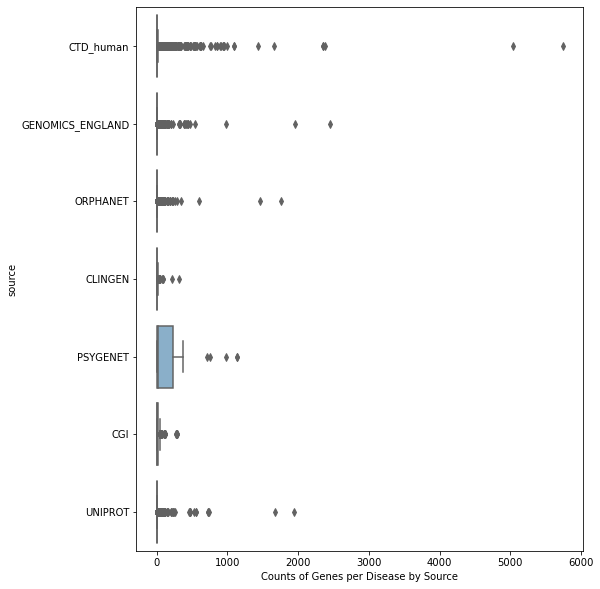

In [49]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Counts of Genes per Disease by Source',
                 data = SumDisease, palette="Set3", orient = 'h')

<AxesSubplot:xlabel='Log of Counts of Genes per Disease by Source', ylabel='source'>

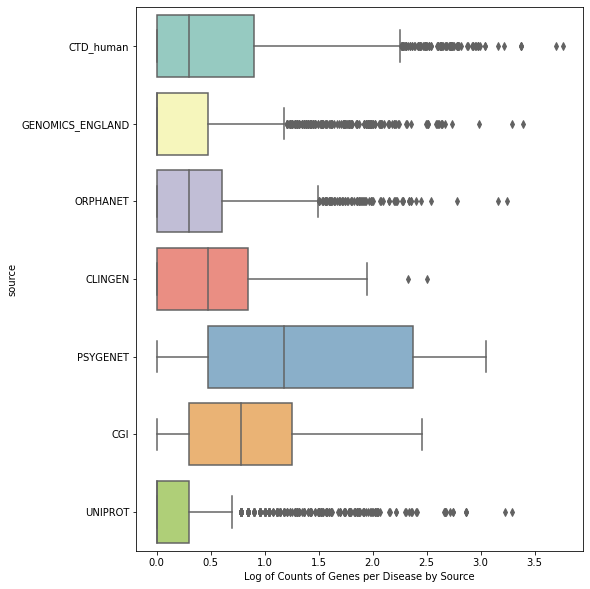

In [50]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Log of Counts of Genes per Disease by Source',
                 data = SumDisease, palette="Set3", orient = 'h')

Text(0, 0.5, 'Frequency')

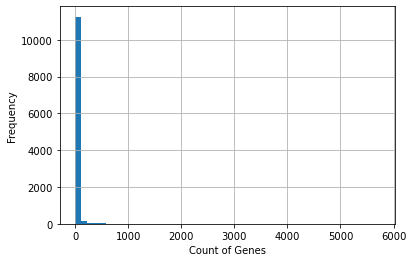

In [51]:
SumDisease['Counts of Genes per Disease by Source'].hist(bins=50)
plt.xlabel("Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

Text(0, 0.5, 'Frequency')

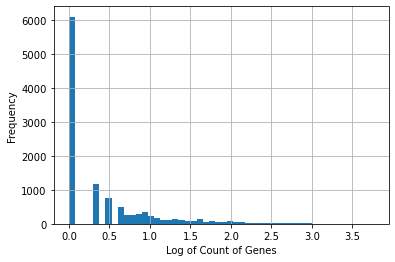

In [52]:
SumDisease['Log of Counts of Genes per Disease by Source'].hist(bins=50)
plt.xlabel("Log of Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

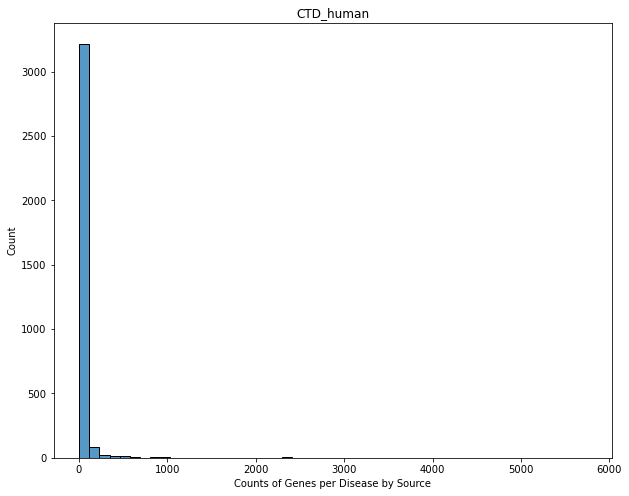

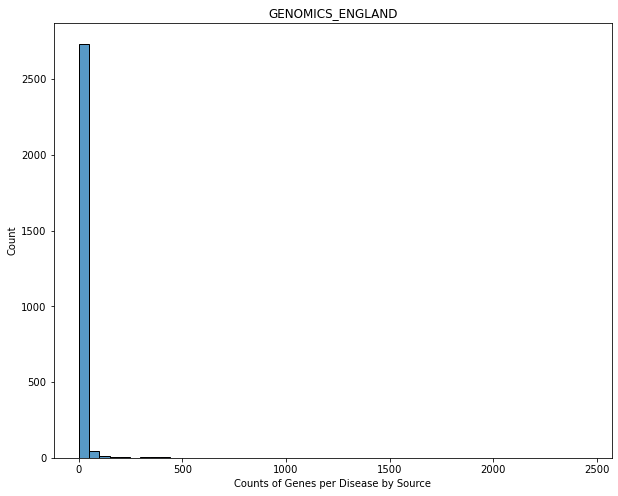

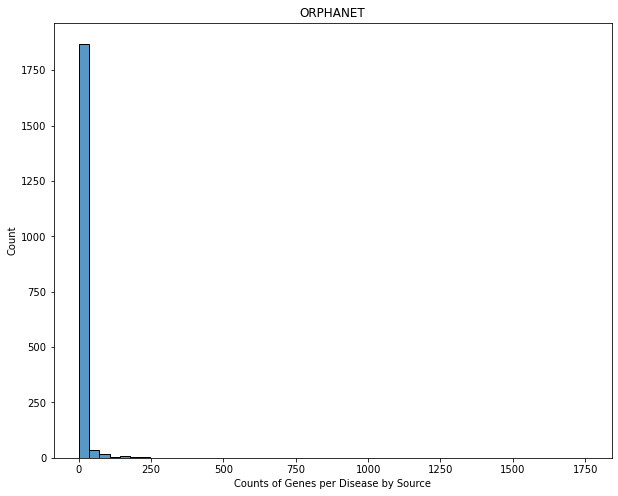

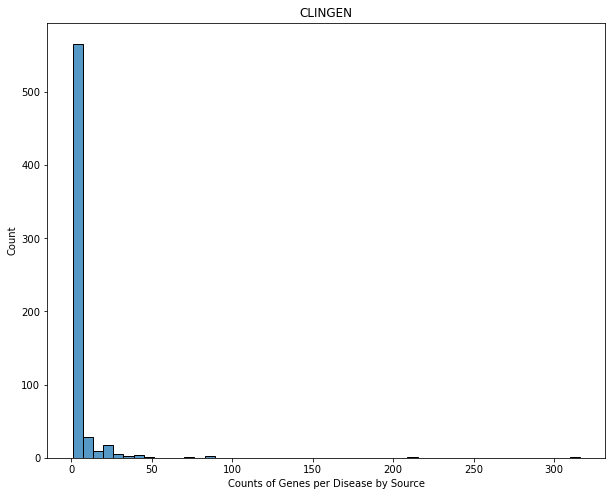

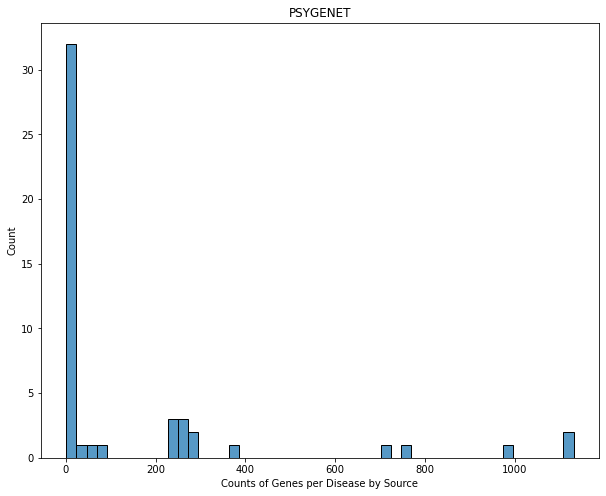

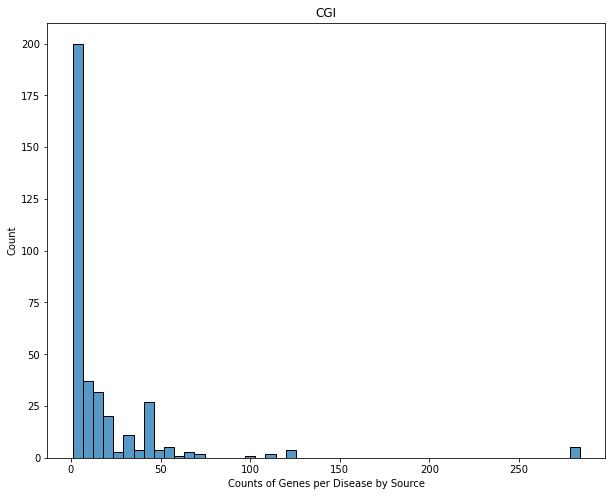

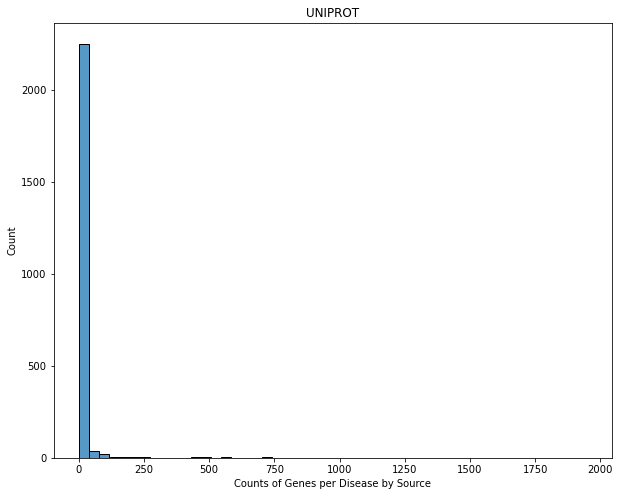

In [53]:
for i, source in enumerate(SumDisease.source.unique(), 1):
    data = SumDisease[SumDisease.source == source]
    fig, ax = plt.subplots(figsize = (10,8))
    sns.histplot(data['Counts of Genes per Disease by Source'], bins=50)
    plt.title(source)

## Find out all the disease terms that have ≥n_s genes (after propagation) from 3 different sources. Use n_s = 10 to begin with:

In [66]:
propagatedafter = propagated[propagated['geneSet'].map(lambda d: len(d)) >= 10]
propagatedafter

,DOID,geneSet,source,diseaseName
2,DOID:863,"{25861, 2566, 22926, 23568, 785, 9364, 1687, 2...",CLINGEN,nervous system disease
3,DOID:7,"{7168, 51206, 2566, 3081, 23568, 4624, 4625, 4...",CLINGEN,disease of anatomical entity
4,DOID:4,"{7168, 51206, 2566, 3081, 23568, 4624, 4625, 4...",CLINGEN,disease
7,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease
10,DOID:16,"{55651, 7046, 362, 2161, 6898, 2707, 5271, 940...",CLINGEN,integumentary system disease
...,...,...,...,...
1852,DOID:3111,"{140609, 3717, 5894, 22983, 6792, 27148, 54861...",UNIPROT,cystadenocarcinoma
1869,DOID:684,"{51201, 57509, 10855, 2056, 1033, 4233, 5290, ...",UNIPROT,hepatocellular carcinoma
1870,DOID:686,"{51201, 57509, 10855, 2056, 1033, 4233, 5290, ...",UNIPROT,liver carcinoma
1886,DOID:8692,"{2146, 339970, 3717, 54790, 7403, 29072, 2322,...",UNIPROT,myeloid leukemia


In [67]:
propagatedafter

,DOID,geneSet,source,diseaseName
2,DOID:863,"{25861, 2566, 22926, 23568, 785, 9364, 1687, 2...",CLINGEN,nervous system disease
3,DOID:7,"{7168, 51206, 2566, 3081, 23568, 4624, 4625, 4...",CLINGEN,disease of anatomical entity
4,DOID:4,"{7168, 51206, 2566, 3081, 23568, 4624, 4625, 4...",CLINGEN,disease
7,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease
10,DOID:16,"{55651, 7046, 362, 2161, 6898, 2707, 5271, 940...",CLINGEN,integumentary system disease
...,...,...,...,...
1852,DOID:3111,"{140609, 3717, 5894, 22983, 6792, 27148, 54861...",UNIPROT,cystadenocarcinoma
1869,DOID:684,"{51201, 57509, 10855, 2056, 1033, 4233, 5290, ...",UNIPROT,hepatocellular carcinoma
1870,DOID:686,"{51201, 57509, 10855, 2056, 1033, 4233, 5290, ...",UNIPROT,liver carcinoma
1886,DOID:8692,"{2146, 339970, 3717, 54790, 7403, 29072, 2322,...",UNIPROT,myeloid leukemia


In [29]:
propagatedafter2 = propagatedafter.groupby(by = ['DOID', 'diseaseName'])['source'].apply(lambda x: set(x))
propagatedafter2 = propagatedafter2.reset_index()

propagatedafter3 = propagatedafter2[propagatedafter2['source'].map(lambda d: len(d)) >= 3]
propagatedafter3

,DOID,diseaseName,source
0,DOID:0014667,disease of metabolism,"{CTD_human, GENOMICS_ENGLAND, UNIPROT, ORPHANET}"
3,DOID:0050155,sensory system disease,"{CTD_human, UNIPROT, CLINGEN, GENOMICS_ENGLAND..."
5,DOID:0050161,lower respiratory tract disease,"{CTD_human, UNIPROT, CGI, GENOMICS_ENGLAND, OR..."
6,DOID:0050177,monogenic disease,"{CTD_human, GENOMICS_ENGLAND, UNIPROT, ORPHANET}"
8,DOID:0050387,nonpapillary renal cell carcinoma,"{CTD_human, CGI, UNIPROT}"
...,...,...,...
824,DOID:9256,colorectal cancer,"{CTD_human, GENOMICS_ENGLAND, UNIPROT}"
827,DOID:936,brain disease,"{CTD_human, UNIPROT, CGI, CLINGEN, GENOMICS_EN..."
833,DOID:9500,leukocyte disease,"{GENOMICS_ENGLAND, CTD_human, CGI, ORPHANET}"
835,DOID:9553,adrenal gland disease,"{CTD_human, GENOMICS_ENGLAND, ORPHANET}"


In [30]:
propagatedafter4 = pd.DataFrame([(c, tup.DOID, tup.diseaseName) for tup in propagatedafter3.itertuples() for c in tup.source])
propagatedafter4 = propagatedafter4.rename(columns= {0: 'source', 1: 'DOID', 2: 'diseaseName'})
propagatedafter4

,source,DOID,diseaseName
0,CTD_human,DOID:0014667,disease of metabolism
1,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism
2,UNIPROT,DOID:0014667,disease of metabolism
3,ORPHANET,DOID:0014667,disease of metabolism
4,CTD_human,DOID:0050155,sensory system disease
...,...,...,...
866,ORPHANET,DOID:9553,adrenal gland disease
867,CTD_human,DOID:9884,muscular dystrophy
868,GENOMICS_ENGLAND,DOID:9884,muscular dystrophy
869,UNIPROT,DOID:9884,muscular dystrophy


In [31]:
propagatedafter5 = propagatedafter4.merge(propagatedafter)

In [32]:
propagatedafter5

,source,DOID,diseaseName,geneSet
0,CTD_human,DOID:0014667,disease of metabolism,"{4864, 2176, 1281, 5251, 2, 3586, 775, 2184, 4..."
1,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism,"{4864, 3170, 6609, 6898, 10577, 538, 112817, 3..."
2,UNIPROT,DOID:0014667,disease of metabolism,"{4864, 6609, 6898, 10577, 133396, 56922, 11281..."
3,ORPHANET,DOID:0014667,disease of metabolism,"{6609, 6898, 112817, 133396, 348, 64087, 56922..."
4,CTD_human,DOID:0050155,sensory system disease,"{3075, 1029, 3078, 1030, 23562, 9227, 2059, 30..."
...,...,...,...,...
866,ORPHANET,DOID:9553,adrenal gland disease,"{866, 5573, 64072, 9101, 8622, 1583, 1584, 158..."
867,CTD_human,DOID:9884,muscular dystrophy,"{7169, 29954, 7170, 1281, 1026, 1291, 1292, 12..."
868,GENOMICS_ENGLAND,DOID:9884,muscular dystrophy,"{7169, 7170, 29954, 9987, 1291, 1292, 1293, 47..."
869,UNIPROT,DOID:9884,muscular dystrophy,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1..."


In [33]:
templist = []
for index, row, in propagatedafter5.iterrows():
    templist.append(len(row['geneSet']))
propagatedafter5['numgenes_prop'] = templist
propagatedafter5

,source,DOID,diseaseName,geneSet,numgenes_prop
0,CTD_human,DOID:0014667,disease of metabolism,"{4864, 2176, 1281, 5251, 2, 3586, 775, 2184, 4...",72
1,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism,"{4864, 3170, 6609, 6898, 10577, 538, 112817, 3...",15
2,UNIPROT,DOID:0014667,disease of metabolism,"{4864, 6609, 6898, 10577, 133396, 56922, 11281...",10
3,ORPHANET,DOID:0014667,disease of metabolism,"{6609, 6898, 112817, 133396, 348, 64087, 56922...",10
4,CTD_human,DOID:0050155,sensory system disease,"{3075, 1029, 3078, 1030, 23562, 9227, 2059, 30...",536
...,...,...,...,...,...
866,ORPHANET,DOID:9553,adrenal gland disease,"{866, 5573, 64072, 9101, 8622, 1583, 1584, 158...",12
867,CTD_human,DOID:9884,muscular dystrophy,"{7169, 29954, 7170, 1281, 1026, 1291, 1292, 12...",71
868,GENOMICS_ENGLAND,DOID:9884,muscular dystrophy,"{7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...",55
869,UNIPROT,DOID:9884,muscular dystrophy,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...",41


## Redo of this process:

In [54]:
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease
2,DOID:7,"{7168, 51206, 2566, 3081, 23568, 4624, 4625, 4...",CLINGEN,disease of anatomical entity
3,DOID:4,"{7168, 51204, 51206, 3081, 23568, 125972, 8399...",CLINGEN,disease
4,DOID:2952,"{2299, 3766}",CLINGEN,inner ear disease
...,...,...,...,...
2327,DOID:4079,{8642},UNIPROT,heart valve disease
2328,DOID:61,{8642},UNIPROT,mitral valve disease
2329,DOID:9883,{1756},UNIPROT,Becker muscular dystrophy
2330,DOID:9955,{1482},UNIPROT,hypoplastic left heart syndrome


In [55]:
propagatedafter = propagated.groupby(by = ['DOID', 'diseaseName'])['source'].apply(lambda x: set(x))
propagatedafter = propagatedafter.reset_index()

propagatedafter2 = propagatedafter[propagatedafter['source'].map(lambda d: len(d)) >= 3]
propagatedafter2

,DOID,diseaseName,source
1,DOID:0014667,disease of metabolism,"{CLINGEN, GENOMICS_ENGLAND, CGI, PSYGENET, UNI..."
4,DOID:0050013,carbohydrate metabolism disease,"{ORPHANET, UNIPROT, CTD_human, GENOMICS_ENGLAND}"
5,DOID:0050032,mineral metabolism disease,"{ORPHANET, UNIPROT, CTD_human, GENOMICS_ENGLAND}"
6,DOID:0050117,disease by infectious agent,"{ORPHANET, UNIPROT, CTD_human, GENOMICS_ENGLAND}"
7,DOID:0050120,hemophagocytic lymphohistiocytosis,"{ORPHANET, UNIPROT, CTD_human, GENOMICS_ENGLAND}"
...,...,...,...
3798,DOID:9884,muscular dystrophy,"{ORPHANET, UNIPROT, CTD_human, GENOMICS_ENGLAND}"
3802,DOID:9952,acute lymphocytic leukemia,"{UNIPROT, CGI, CTD_human, GENOMICS_ENGLAND}"
3803,DOID:9955,hypoplastic left heart syndrome,"{ORPHANET, UNIPROT, CTD_human, GENOMICS_ENGLAND}"
3805,DOID:9970,obesity,"{UNIPROT, CTD_human, GENOMICS_ENGLAND}"


In [56]:
propagatedafter3 = pd.DataFrame([(c, tup.DOID, tup.diseaseName) for tup in propagatedafter2.itertuples() for c in tup.source])
propagatedafter3 = propagatedafter3.rename(columns= {0: 'source', 1: 'DOID', 2: 'diseaseName'})
propagatedafter3

,source,DOID,diseaseName
0,CLINGEN,DOID:0014667,disease of metabolism
1,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism
2,CGI,DOID:0014667,disease of metabolism
3,PSYGENET,DOID:0014667,disease of metabolism
4,UNIPROT,DOID:0014667,disease of metabolism
...,...,...,...
9717,CTD_human,DOID:9970,obesity
9718,GENOMICS_ENGLAND,DOID:9970,obesity
9719,CGI,DOID:999,hypereosinophilic syndrome
9720,CTD_human,DOID:999,hypereosinophilic syndrome


In [57]:
propagatedafter4 = propagatedafter3.merge(propagated)
propagatedafter4

,source,DOID,diseaseName,geneSet
0,CLINGEN,DOID:0014667,disease of metabolism,"{51204, 3081, 9997, 374291, 55572, 275, 55065,..."
1,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism,"{644096, 3073, 3074, 10243, 7172, 3077, 378884..."
2,CGI,DOID:0014667,disease of metabolism,{4615}
3,PSYGENET,DOID:0014667,disease of metabolism,"{217, 125}"
4,UNIPROT,DOID:0014667,disease of metabolism,"{644096, 1537, 514, 140803, 90624, 3077, 10243..."
...,...,...,...,...
9717,CTD_human,DOID:9970,obesity,"{407040, 5122, 1528, 1545, 1050, 3099, 51738, ..."
9718,GENOMICS_ENGLAND,DOID:9970,obesity,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123..."
9719,CGI,DOID:999,hypereosinophilic syndrome,"{55500, 5156}"
9720,CTD_human,DOID:999,hypereosinophilic syndrome,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3..."


In [58]:
templist = []
for index, row, in propagatedafter4.iterrows():
    templist.append(len(row['geneSet']))
propagatedafter4['numgenes_prop'] = templist
propagatedafter4

,source,DOID,diseaseName,geneSet,numgenes_prop
0,CLINGEN,DOID:0014667,disease of metabolism,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...",88
1,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism,"{644096, 3073, 3074, 10243, 7172, 3077, 378884...",413
2,CGI,DOID:0014667,disease of metabolism,{4615},1
3,PSYGENET,DOID:0014667,disease of metabolism,"{217, 125}",2
4,UNIPROT,DOID:0014667,disease of metabolism,"{644096, 1537, 514, 140803, 90624, 3077, 10243...",252
...,...,...,...,...,...
9717,CTD_human,DOID:9970,obesity,"{407040, 5122, 1528, 1545, 1050, 3099, 51738, ...",188
9718,GENOMICS_ENGLAND,DOID:9970,obesity,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123...",26
9719,CGI,DOID:999,hypereosinophilic syndrome,"{55500, 5156}",2
9720,CTD_human,DOID:999,hypereosinophilic syndrome,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3...",11


In [59]:
tempdict = {}
for index, row, in propagatedafter4.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneSet']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneSet']})
tempdict

{'DOID:0014667': {2,
  8195,
  12,
  18,
  19,
  4123,
  4125,
  4126,
  4128,
  32,
  34,
  35,
  37,
  147495,
  43,
  26060,
  131118,
  4143,
  47,
  51,
  54,
  340024,
  4153,
  4160,
  4175,
  122961,
  53345,
  4199,
  109,
  111,
  8309,
  4217,
  124,
  125,
  127,
  132,
  123016,
  142,
  153,
  154,
  155,
  158,
  177,
  178,
  181,
  183,
  151742,
  191,
  196,
  197,
  207,
  208,
  210,
  211,
  212,
  114904,
  4313,
  216,
  217,
  4312,
  219,
  4318,
  226,
  229,
  4329,
  8431,
  4337,
  4338,
  249,
  4351,
  4358,
  4360,
  102465802,
  275,
  28958,
  291,
  308,
  8504,
  8517,
  8522,
  335,
  336,
  337,
  338,
  8527,
  344,
  345,
  348,
  351,
  353,
  355,
  356,
  364,
  367,
  383,
  53632,
  4502,
  406,
  8600,
  29078,
  410,
  411,
  4508,
  412,
  4509,
  4512,
  57761,
  4513,
  4514,
  8614,
  427,
  790955,
  4524,
  435,
  29108,
  438,
  4535,
  440,
  4536,
  4537,
  4540,
  445,
  4541,
  8639,
  4544,
  4548,
  8644,
  4552,
  463,
  467

In [60]:
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneSet'])
df

,DOID,geneSet
0,DOID:0014667,"{2, 8195, 12, 18, 19, 4123, 4125, 4126, 4128, ..."
1,DOID:0050013,"{5126, 1036, 3087, 83986, 55315, 3098, 10269, ..."
2,DOID:0050032,"{2056, 9213, 3606, 54809, 11035, 796, 2591, 79..."
3,DOID:0050117,"{9997, 11277, 51191, 54809, 9246, 23586, 8743,..."
4,DOID:0050120,"{8676, 84868, 331, 201294, 5551, 149041, 27259..."
...,...,...
2521,DOID:9884,"{7169, 7170, 1026, 4625, 3094, 4633, 43, 51763..."
2522,DOID:9952,"{2052, 1029, 1544, 1545, 10, 55824, 6929, 2322..."
2523,DOID:9955,"{56136, 9752, 2697, 1482, 79595}"
2524,DOID:9970,"{23040, 407040, 5122, 8195, 1545, 1050, 3099, ..."


In [61]:
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneSet']))
df['numgenes_prop'] = templist
df

,DOID,geneSet,numgenes_prop
0,DOID:0014667,"{2, 8195, 12, 18, 19, 4123, 4125, 4126, 4128, ...",1106
1,DOID:0050013,"{5126, 1036, 3087, 83986, 55315, 3098, 10269, ...",350
2,DOID:0050032,"{2056, 9213, 3606, 54809, 11035, 796, 2591, 79...",67
3,DOID:0050117,"{9997, 11277, 51191, 54809, 9246, 23586, 8743,...",65
4,DOID:0050120,"{8676, 84868, 331, 201294, 5551, 149041, 27259...",8
...,...,...,...
2521,DOID:9884,"{7169, 7170, 1026, 4625, 3094, 4633, 43, 51763...",102
2522,DOID:9952,"{2052, 1029, 1544, 1545, 10, 55824, 6929, 2322...",63
2523,DOID:9955,"{56136, 9752, 2697, 1482, 79595}",5
2524,DOID:9970,"{23040, 407040, 5122, 8195, 1545, 1050, 3099, ...",206


In [62]:
propagatedafter5 = df.copy()

In [63]:
propagatedafter5 = propagatedafter5.reset_index()
propagatedafter5 = propagatedafter5[propagatedafter5['numgenes_prop'].map(lambda d: d) >= 10]
propagatedafter5

,index,DOID,geneSet,numgenes_prop
0,0,DOID:0014667,"{2, 8195, 12, 18, 19, 4123, 4125, 4126, 4128, ...",1106
1,1,DOID:0050013,"{5126, 1036, 3087, 83986, 55315, 3098, 10269, ...",350
2,2,DOID:0050032,"{2056, 9213, 3606, 54809, 11035, 796, 2591, 79...",67
3,3,DOID:0050117,"{9997, 11277, 51191, 54809, 9246, 23586, 8743,...",65
8,8,DOID:0050155,"{8195, 2055, 2059, 79883, 100048912, 18, 55315...",839
...,...,...,...,...
2517,2517,DOID:987,"{387, 5573, 142, 4047, 5654, 4953, 1244, 8797,...",19
2521,2521,DOID:9884,"{7169, 7170, 1026, 4625, 3094, 4633, 43, 51763...",102
2522,2522,DOID:9952,"{2052, 1029, 1544, 1545, 10, 55824, 6929, 2322...",63
2524,2524,DOID:9970,"{23040, 407040, 5122, 8195, 1545, 1050, 3099, ...",206


## Find out all the disease terms that have ≥n_d direct gene annotations (i.e., without propagation). Use n_d = 5 to begin with:

In [53]:
desired12before = desired12.drop(columns = ['diseaseName'])
desired12before = desired12before.drop_duplicates(subset=['DOID', 'source'])
desired12before

,DOID,source,geneId
2,DOID:0002116,CTD_human,{3440}
3,DOID:0002116,GENOMICS_ENGLAND,{23299}
5,DOID:0040084,CTD_human,"{1673, 23411, 10747, 3576, 5594, 5595}"
7,DOID:0040099,CTD_human,{2147}
8,DOID:0050120,CTD_human,{84868}
...,...,...,...
20005,DOID:998,CTD_human,"{3123, 3117}"
20006,DOID:999,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [54]:
desired12before = desired12before[desired12before['geneId'].map(lambda d: len(d)) >= 5]
desired12before

,DOID,source,geneId
5,DOID:0040084,CTD_human,"{1673, 23411, 10747, 3576, 5594, 5595}"
13,DOID:0050127,CTD_human,"{4233, 3596, 84687, 563, 1080, 5304}"
22,DOID:0050156,CTD_human,"{3091, 729238, 91039, 10144, 2852, 51750, 1832..."
25,DOID:0050156,ORPHANET,"{10144, 7012, 653509, 51750, 7015, 1832, 6440,..."
41,DOID:0050328,GENOMICS_ENGLAND,"{2304, 169792, 7173, 55143, 7080, 5449, 7849, ..."
...,...,...,...
19987,DOID:9952,CGI,"{10019, 3716, 3717, 3718, 1387, 64109, 10320, ..."
19988,DOID:9952,CTD_human,"{2052, 1029, 1544, 1545, 10, 55824, 6929, 2322..."
19995,DOID:9955,CTD_human,"{56136, 2697, 1482, 79595, 9752}"
20006,DOID:999,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"


In [55]:
templist = []
for index, row, in desired12before.iterrows():
    templist.append(disease_ontology.nodes[row['DOID']]["name"])
desired12before['diseaseName'] = templist
desired12before

<ipython-input-55-46c7e5d9ccec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired12before['diseaseName'] = templist


,DOID,source,geneId,diseaseName
5,DOID:0040084,CTD_human,"{1673, 23411, 10747, 3576, 5594, 5595}",Streptococcus pneumonia
13,DOID:0050127,CTD_human,"{4233, 3596, 84687, 563, 1080, 5304}",sinusitis
22,DOID:0050156,CTD_human,"{3091, 729238, 91039, 10144, 2852, 51750, 1832...",idiopathic pulmonary fibrosis
25,DOID:0050156,ORPHANET,"{10144, 7012, 653509, 51750, 7015, 1832, 6440,...",idiopathic pulmonary fibrosis
41,DOID:0050328,GENOMICS_ENGLAND,"{2304, 169792, 7173, 55143, 7080, 5449, 7849, ...",congenital hypothyroidism
...,...,...,...,...
19987,DOID:9952,CGI,"{10019, 3716, 3717, 3718, 1387, 64109, 10320, ...",acute lymphocytic leukemia
19988,DOID:9952,CTD_human,"{2052, 1029, 1544, 1545, 10, 55824, 6929, 2322...",acute lymphocytic leukemia
19995,DOID:9955,CTD_human,"{56136, 2697, 1482, 79595, 9752}",hypoplastic left heart syndrome
20006,DOID:999,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}",hypereosinophilic syndrome


In [56]:
templist = []
for index, row, in desired12before.iterrows():
    templist.append(len(row['geneId']))
desired12before['numgenes_dir'] = templist
desired12before

<ipython-input-56-b7db1f26b505>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired12before['numgenes_dir'] = templist


,DOID,source,geneId,diseaseName,numgenes_dir
5,DOID:0040084,CTD_human,"{1673, 23411, 10747, 3576, 5594, 5595}",Streptococcus pneumonia,6
13,DOID:0050127,CTD_human,"{4233, 3596, 84687, 563, 1080, 5304}",sinusitis,6
22,DOID:0050156,CTD_human,"{3091, 729238, 91039, 10144, 2852, 51750, 1832...",idiopathic pulmonary fibrosis,19
25,DOID:0050156,ORPHANET,"{10144, 7012, 653509, 51750, 7015, 1832, 6440,...",idiopathic pulmonary fibrosis,14
41,DOID:0050328,GENOMICS_ENGLAND,"{2304, 169792, 7173, 55143, 7080, 5449, 7849, ...",congenital hypothyroidism,12
...,...,...,...,...,...
19987,DOID:9952,CGI,"{10019, 3716, 3717, 3718, 1387, 64109, 10320, ...",acute lymphocytic leukemia,13
19988,DOID:9952,CTD_human,"{2052, 1029, 1544, 1545, 10, 55824, 6929, 2322...",acute lymphocytic leukemia,50
19995,DOID:9955,CTD_human,"{56136, 2697, 1482, 79595, 9752}",hypoplastic left heart syndrome,5
20006,DOID:999,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}",hypereosinophilic syndrome,7


## Redo of this process:

In [64]:
desired12

,DOID,diseaseName,source,geneId
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
5,DOID:0040084,Streptococcal pneumonia,CTD_human,"{1673, 23411, 10747, 3576, 5594, 5595}"
7,DOID:0040099,"Skin Diseases, Vascular",CTD_human,{2147}
8,DOID:0050120,Familial Hemophagocytic Lymphocytosis,CTD_human,{84868}
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [65]:
tempdict = {}
for index, row, in desired12.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneId']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneId']})
tempdict

{'DOID:0002116': {3440, 23299},
 'DOID:0040084': {1673, 3576, 5594, 5595, 10747, 23411},
 'DOID:0040099': {2147},
 'DOID:0050120': {331, 5551, 6813, 8676, 84868, 149041, 201294},
 'DOID:0050127': {563, 1080, 3596, 4233, 5304, 84687, 345895},
 'DOID:0050152': {4843},
 'DOID:0050156': {21,
  1832,
  2099,
  2852,
  3091,
  4314,
  5073,
  5328,
  6440,
  6774,
  7012,
  7015,
  7474,
  10144,
  23250,
  51750,
  79991,
  91039,
  653509,
  727897,
  729238},
 'DOID:0050167': {326},
 'DOID:0050168': {326},
 'DOID:0050185': {10747},
 'DOID:0050214': {5339, 9581},
 'DOID:0050328': {1482,
  2304,
  3547,
  5172,
  5449,
  7038,
  7080,
  7173,
  7252,
  7253,
  7849,
  50506,
  55143,
  169792,
  389434},
 'DOID:0050332': {2299, 3766, 5172},
 'DOID:0050335': {8787, 388531},
 'DOID:0050336': {2260, 6569, 8856},
 'DOID:0050387': {43,
  95,
  210,
  216,
  238,
  240,
  242,
  307,
  317,
  332,
  353,
  472,
  590,
  657,
  822,
  835,
  949,
  1265,
  1381,
  1410,
  1508,
  1509,
  1612,
  1

In [66]:
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneId'])
df

,DOID,geneId
0,DOID:0002116,"{3440, 23299}"
1,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}"
2,DOID:0040099,{2147}
3,DOID:0050120,"{149041, 84868, 8676, 331, 6813, 201294, 5551}"
4,DOID:0050127,"{563, 345895, 1080, 4233, 3596, 5304, 84687}"
...,...,...
3375,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4..."
3376,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255..."
3377,DOID:998,"{3123, 3117}"
3378,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}"


In [67]:
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneId']))
df['numgenes_dir'] = templist
df

,DOID,geneId,numgenes_dir
0,DOID:0002116,"{3440, 23299}",2
1,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}",6
2,DOID:0040099,{2147},1
3,DOID:0050120,"{149041, 84868, 8676, 331, 6813, 201294, 5551}",7
4,DOID:0050127,"{563, 345895, 1080, 4233, 3596, 5304, 84687}",7
...,...,...,...
3375,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4...",139
3376,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",9
3377,DOID:998,"{3123, 3117}",2
3378,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}",8


In [68]:
desired12before = df.copy()

In [69]:
desired12before = desired12before.reset_index()
desired12before = desired12before[desired12before['numgenes_dir'].map(lambda d: d) >= 5]
desired12before

,index,DOID,geneId,numgenes_dir
1,1,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}",6
3,3,DOID:0050120,"{149041, 84868, 8676, 331, 6813, 201294, 5551}",7
4,4,DOID:0050127,"{563, 345895, 1080, 4233, 3596, 5304, 84687}",7
6,6,DOID:0050156,"{3091, 21, 729238, 91039, 10144, 2852, 51750, ...",21
11,11,DOID:0050328,"{2304, 169792, 7173, 5449, 1482, 50506, 7252, ...",15
...,...,...,...,...
3374,3374,DOID:9970,"{23040, 407040, 5122, 8195, 1545, 1050, 3099, ...",205
3375,3375,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4...",139
3376,3376,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",9
3378,3378,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}",8


## Merging Process:

In [70]:
propagatedafter5 = propagatedafter5.drop(columns = 'index')
propagatedafter5

,DOID,geneSet,numgenes_prop
0,DOID:0014667,"{2, 8195, 12, 18, 19, 4123, 4125, 4126, 4128, ...",1106
1,DOID:0050013,"{5126, 1036, 3087, 83986, 55315, 3098, 10269, ...",350
2,DOID:0050032,"{2056, 9213, 3606, 54809, 11035, 796, 2591, 79...",67
3,DOID:0050117,"{9997, 11277, 51191, 54809, 9246, 23586, 8743,...",65
8,DOID:0050155,"{8195, 2055, 2059, 79883, 100048912, 18, 55315...",839
...,...,...,...
2517,DOID:987,"{387, 5573, 142, 4047, 5654, 4953, 1244, 8797,...",19
2521,DOID:9884,"{7169, 7170, 1026, 4625, 3094, 4633, 43, 51763...",102
2522,DOID:9952,"{2052, 1029, 1544, 1545, 10, 55824, 6929, 2322...",63
2524,DOID:9970,"{23040, 407040, 5122, 8195, 1545, 1050, 3099, ...",206


In [71]:
desired12before = desired12before.drop(columns = 'index')
desired12before

,DOID,geneId,numgenes_dir
1,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}",6
3,DOID:0050120,"{149041, 84868, 8676, 331, 6813, 201294, 5551}",7
4,DOID:0050127,"{563, 345895, 1080, 4233, 3596, 5304, 84687}",7
6,DOID:0050156,"{3091, 21, 729238, 91039, 10144, 2852, 51750, ...",21
11,DOID:0050328,"{2304, 169792, 7173, 5449, 1482, 50506, 7252, ...",15
...,...,...,...
3374,DOID:9970,"{23040, 407040, 5122, 8195, 1545, 1050, 3099, ...",205
3375,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4...",139
3376,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",9
3378,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}",8


In [72]:
mergedNew = propagatedafter5.merge(desired12before, how = 'inner')
mergedNew = mergedNew.drop(columns = ['geneSet', 'geneId'])
mergedNew

,DOID,numgenes_prop,numgenes_dir
0,DOID:0050156,21,21
1,DOID:0050328,13,15
2,DOID:0050387,148,148
3,DOID:0050444,15,15
4,DOID:0050451,25,28
...,...,...,...
570,DOID:987,19,19
571,DOID:9884,102,8
572,DOID:9952,63,63
573,DOID:9970,206,205


In [73]:
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease
2,DOID:7,"{7168, 51206, 2566, 3081, 23568, 4624, 4625, 4...",CLINGEN,disease of anatomical entity
3,DOID:4,"{7168, 51204, 51206, 3081, 23568, 125972, 8399...",CLINGEN,disease
4,DOID:2952,"{2299, 3766}",CLINGEN,inner ear disease
...,...,...,...,...
2327,DOID:4079,{8642},UNIPROT,heart valve disease
2328,DOID:61,{8642},UNIPROT,mitral valve disease
2329,DOID:9883,{1756},UNIPROT,Becker muscular dystrophy
2330,DOID:9955,{1482},UNIPROT,hypoplastic left heart syndrome


In [74]:
test = mergedNew.merge(propagated)
test

,DOID,numgenes_prop,numgenes_dir,geneSet,source,diseaseName
0,DOID:0050156,21,21,"{5328, 5073, 23250, 3091, 729238, 727897, 4314...",CTD_human,idiopathic pulmonary fibrosis
1,DOID:0050156,21,21,"{727897, 653509, 729238}",GENOMICS_ENGLAND,idiopathic pulmonary fibrosis
2,DOID:0050156,21,21,"{10144, 7012, 653509, 51750, 7015, 1832, 6440,...",ORPHANET,idiopathic pulmonary fibrosis
3,DOID:0050156,21,21,{729238},UNIPROT,idiopathic pulmonary fibrosis
4,DOID:0050328,13,15,"{7201, 7067, 7173, 7849, 50506, 1482, 55532, 7...",CTD_human,congenital hypothyroidism
...,...,...,...,...,...,...
2291,DOID:9970,206,205,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123...",GENOMICS_ENGLAND,obesity
2292,DOID:9970,206,205,"{4160, 5468, 7352}",UNIPROT,obesity
2293,DOID:999,14,8,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3...",CTD_human,hypereosinophilic syndrome
2294,DOID:999,14,8,"{55500, 5156}",CGI,hypereosinophilic syndrome


In [75]:
mergedNew2 = test.rename(columns = {'DOID': 'dis_doid', 'diseaseName': 'dis_name'})
mergedNew2 = mergedNew2[['dis_doid', 'dis_name', 'source', 'numgenes_prop', 'numgenes_dir', 'geneSet']]
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet
0,DOID:0050156,idiopathic pulmonary fibrosis,CTD_human,21,21,"{5328, 5073, 23250, 3091, 729238, 727897, 4314..."
1,DOID:0050156,idiopathic pulmonary fibrosis,GENOMICS_ENGLAND,21,21,"{727897, 653509, 729238}"
2,DOID:0050156,idiopathic pulmonary fibrosis,ORPHANET,21,21,"{10144, 7012, 653509, 51750, 7015, 1832, 6440,..."
3,DOID:0050156,idiopathic pulmonary fibrosis,UNIPROT,21,21,{729238}
4,DOID:0050328,congenital hypothyroidism,CTD_human,13,15,"{7201, 7067, 7173, 7849, 50506, 1482, 55532, 7..."
...,...,...,...,...,...,...
2291,DOID:9970,obesity,GENOMICS_ENGLAND,206,205,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123..."
2292,DOID:9970,obesity,UNIPROT,206,205,"{4160, 5468, 7352}"
2293,DOID:999,hypereosinophilic syndrome,CTD_human,14,8,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3..."
2294,DOID:999,hypereosinophilic syndrome,CGI,14,8,"{55500, 5156}"


In [76]:
mergedNew2['numgenes_CLINGEN'] = np.NaN
mergedNew2['numgenes_CGI'] = np.NaN
mergedNew2['numgenes_CTD_human'] = np.NaN
mergedNew2['numgenes_GENOMICS_ENGLAND'] = np.NaN
mergedNew2['numgenes_ORPHANET'] = np.NaN
mergedNew2['numgenes_PSYGENET'] = np.NaN
mergedNew2['numgenes_UNIPROT'] = np.NaN
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050156,idiopathic pulmonary fibrosis,CTD_human,21,21,"{5328, 5073, 23250, 3091, 729238, 727897, 4314...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DOID:0050156,idiopathic pulmonary fibrosis,GENOMICS_ENGLAND,21,21,"{727897, 653509, 729238}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DOID:0050156,idiopathic pulmonary fibrosis,ORPHANET,21,21,"{10144, 7012, 653509, 51750, 7015, 1832, 6440,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DOID:0050156,idiopathic pulmonary fibrosis,UNIPROT,21,21,{729238},NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DOID:0050328,congenital hypothyroidism,CTD_human,13,15,"{7201, 7067, 7173, 7849, 50506, 1482, 55532, 7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,DOID:9970,obesity,GENOMICS_ENGLAND,206,205,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2292,DOID:9970,obesity,UNIPROT,206,205,"{4160, 5468, 7352}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2293,DOID:999,hypereosinophilic syndrome,CTD_human,14,8,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2294,DOID:999,hypereosinophilic syndrome,CGI,14,8,"{55500, 5156}",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'CLINGEN'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_CLINGEN'] = templist
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050156,idiopathic pulmonary fibrosis,CTD_human,21,21,"{5328, 5073, 23250, 3091, 729238, 727897, 4314...",0,NaN,NaN,NaN,NaN,NaN,NaN
1,DOID:0050156,idiopathic pulmonary fibrosis,GENOMICS_ENGLAND,21,21,"{727897, 653509, 729238}",0,NaN,NaN,NaN,NaN,NaN,NaN
2,DOID:0050156,idiopathic pulmonary fibrosis,ORPHANET,21,21,"{10144, 7012, 653509, 51750, 7015, 1832, 6440,...",0,NaN,NaN,NaN,NaN,NaN,NaN
3,DOID:0050156,idiopathic pulmonary fibrosis,UNIPROT,21,21,{729238},0,NaN,NaN,NaN,NaN,NaN,NaN
4,DOID:0050328,congenital hypothyroidism,CTD_human,13,15,"{7201, 7067, 7173, 7849, 50506, 1482, 55532, 7...",0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,DOID:9970,obesity,GENOMICS_ENGLAND,206,205,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123...",0,NaN,NaN,NaN,NaN,NaN,NaN
2292,DOID:9970,obesity,UNIPROT,206,205,"{4160, 5468, 7352}",0,NaN,NaN,NaN,NaN,NaN,NaN
2293,DOID:999,hypereosinophilic syndrome,CTD_human,14,8,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3...",0,NaN,NaN,NaN,NaN,NaN,NaN
2294,DOID:999,hypereosinophilic syndrome,CGI,14,8,"{55500, 5156}",0,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'CGI'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_CGI'] = templist

In [79]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'PSYGENET'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_PSYGENET'] = templist

In [80]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'CTD_human'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_CTD_human'] = templist

In [81]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'GENOMICS_ENGLAND'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_GENOMICS_ENGLAND'] = templist

In [82]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'ORPHANET'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_ORPHANET'] = templist

In [83]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'UNIPROT'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_UNIPROT'] = templist

In [84]:
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050156,idiopathic pulmonary fibrosis,CTD_human,21,21,"{5328, 5073, 23250, 3091, 729238, 727897, 4314...",0,0,19,0,0,0,0
1,DOID:0050156,idiopathic pulmonary fibrosis,GENOMICS_ENGLAND,21,21,"{727897, 653509, 729238}",0,0,0,3,0,0,0
2,DOID:0050156,idiopathic pulmonary fibrosis,ORPHANET,21,21,"{10144, 7012, 653509, 51750, 7015, 1832, 6440,...",0,0,0,0,14,0,0
3,DOID:0050156,idiopathic pulmonary fibrosis,UNIPROT,21,21,{729238},0,0,0,0,0,0,1
4,DOID:0050328,congenital hypothyroidism,CTD_human,13,15,"{7201, 7067, 7173, 7849, 50506, 1482, 55532, 7...",0,0,10,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,DOID:9970,obesity,GENOMICS_ENGLAND,206,205,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123...",0,0,0,26,0,0,0
2292,DOID:9970,obesity,UNIPROT,206,205,"{4160, 5468, 7352}",0,0,0,0,0,0,3
2293,DOID:999,hypereosinophilic syndrome,CTD_human,14,8,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3...",0,0,11,0,0,0,0
2294,DOID:999,hypereosinophilic syndrome,CGI,14,8,"{55500, 5156}",0,2,0,0,0,0,0


In [85]:
ArjunData = mergedNew2[['dis_doid', 'dis_name','numgenes_CLINGEN', 'numgenes_CGI', 'numgenes_CTD_human',
       'numgenes_GENOMICS_ENGLAND', 'numgenes_ORPHANET', 'numgenes_PSYGENET',
       'numgenes_UNIPROT', 'numgenes_dir', 'numgenes_prop']]
ArjunData

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:0050156,idiopathic pulmonary fibrosis,0,0,19,0,0,0,0,21,21
1,DOID:0050156,idiopathic pulmonary fibrosis,0,0,0,3,0,0,0,21,21
2,DOID:0050156,idiopathic pulmonary fibrosis,0,0,0,0,14,0,0,21,21
3,DOID:0050156,idiopathic pulmonary fibrosis,0,0,0,0,0,0,1,21,21
4,DOID:0050328,congenital hypothyroidism,0,0,10,0,0,0,0,15,13
...,...,...,...,...,...,...,...,...,...,...,...
2291,DOID:9970,obesity,0,0,0,26,0,0,0,205,206
2292,DOID:9970,obesity,0,0,0,0,0,0,3,205,206
2293,DOID:999,hypereosinophilic syndrome,0,0,11,0,0,0,0,8,14
2294,DOID:999,hypereosinophilic syndrome,0,2,0,0,0,0,0,8,14


In [86]:
ArjunData2 = ArjunData.groupby(['dis_doid', 'dis_name', 'numgenes_dir', 'numgenes_prop']).sum()
ArjunData2

,,,,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
dis_doid,dis_name,numgenes_dir,numgenes_prop,,,,,,,
DOID:0050156,idiopathic pulmonary fibrosis,21,21,0,0,19,3,14,0,1
DOID:0050328,congenital hypothyroidism,15,13,0,0,10,3,7,0,4
DOID:0050387,nonpapillary renal cell carcinoma,148,148,0,13,128,3,1,0,19
DOID:0050444,infantile Refsum disease,15,15,0,0,2,2,13,0,1
DOID:0050451,Brugada syndrome,28,25,11,0,4,12,13,0,6
...,...,...,...,...,...,...,...,...,...,...
DOID:987,alopecia,19,19,0,0,15,5,1,0,1
DOID:9884,muscular dystrophy,8,102,0,0,71,55,50,0,41
DOID:9952,acute lymphocytic leukemia,63,63,0,13,50,8,0,0,4


In [87]:
ArjunData2 = ArjunData2.reset_index()
ArjunData2

,dis_doid,dis_name,numgenes_dir,numgenes_prop,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050156,idiopathic pulmonary fibrosis,21,21,0,0,19,3,14,0,1
1,DOID:0050328,congenital hypothyroidism,15,13,0,0,10,3,7,0,4
2,DOID:0050387,nonpapillary renal cell carcinoma,148,148,0,13,128,3,1,0,19
3,DOID:0050444,infantile Refsum disease,15,15,0,0,2,2,13,0,1
4,DOID:0050451,Brugada syndrome,28,25,11,0,4,12,13,0,6
...,...,...,...,...,...,...,...,...,...,...,...
570,DOID:987,alopecia,19,19,0,0,15,5,1,0,1
571,DOID:9884,muscular dystrophy,8,102,0,0,71,55,50,0,41
572,DOID:9952,acute lymphocytic leukemia,63,63,0,13,50,8,0,0,4
573,DOID:9970,obesity,205,206,0,0,188,26,0,0,3


In [88]:
ArjunData2 = ArjunData2.sort_values(by = 'numgenes_prop', ascending = False)
ArjunData2

,dis_doid,dis_name,numgenes_dir,numgenes_prop,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
538,DOID:863,nervous system disease,53,2206,37,47,1657,974,601,0,553
521,DOID:77,gastrointestinal system disease,12,1987,5,71,1433,162,76,0,553
290,DOID:1287,cardiovascular system disease,36,1240,71,0,1087,227,163,0,96
378,DOID:2914,immune system disease,49,1059,4,120,907,209,163,0,81
562,DOID:936,brain disease,27,1034,15,32,747,320,156,0,118
...,...,...,...,...,...,...,...,...,...,...,...
396,DOID:3382,liposarcoma,6,10,0,3,6,0,5,0,0
79,DOID:0070025,X-linked dyskeratosis congenita,13,10,0,0,6,2,6,0,1
73,DOID:0060855,autosomal dominant pseudohypoaldosteronism type 1,10,10,0,0,10,3,3,0,2
72,DOID:0060854,autosomal recessive pseudohypoaldosteronism ty...,10,10,0,0,10,3,3,0,2


In [89]:
ArjunData2 = ArjunData2[['dis_doid', 'dis_name','numgenes_CLINGEN', 'numgenes_CGI', 'numgenes_CTD_human',
       'numgenes_GENOMICS_ENGLAND', 'numgenes_ORPHANET', 'numgenes_PSYGENET',
       'numgenes_UNIPROT', 'numgenes_dir', 'numgenes_prop']]
ArjunData2

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
538,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206
521,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987
290,DOID:1287,cardiovascular system disease,71,0,1087,227,163,0,96,36,1240
378,DOID:2914,immune system disease,4,120,907,209,163,0,81,49,1059
562,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034
...,...,...,...,...,...,...,...,...,...,...,...
396,DOID:3382,liposarcoma,0,3,6,0,5,0,0,6,10
79,DOID:0070025,X-linked dyskeratosis congenita,0,0,6,2,6,0,1,13,10
73,DOID:0060855,autosomal dominant pseudohypoaldosteronism type 1,0,0,10,3,3,0,2,10,10
72,DOID:0060854,autosomal recessive pseudohypoaldosteronism ty...,0,0,10,3,3,0,2,10,10


In [90]:
ArjunData2.to_csv('DesiredDataArjun.tsv', index = False, sep = "\t")

In [3]:
ArjunData2 = pd.read_csv('DesiredDataArjun.tsv', sep = '\t')
ArjunData2

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034
1,DOID:5295,intestinal disease,1,55,532,104,7,0,476,8,1026
2,DOID:850,lung disease,1,42,771,53,23,0,109,78,895
3,DOID:10155,intestinal cancer,0,55,406,20,0,0,468,12,846
4,DOID:5672,large intestine cancer,0,54,401,19,0,0,468,878,840
...,...,...,...,...,...,...,...,...,...,...,...
503,DOID:0060854,autosomal recessive pseudohypoaldosteronism ty...,0,0,10,3,3,0,2,10,10
504,DOID:0060855,autosomal dominant pseudohypoaldosteronism type 1,0,0,10,3,3,0,2,10,10
505,DOID:12932,endomyocardial fibrosis,0,0,9,1,1,0,1,13,10
506,DOID:0090043,dystonia 5,0,0,7,3,1,0,1,10,10


In [91]:
templist = []
for index, row, in ArjunData2.iterrows():
    tempcount = 0
    if (row['numgenes_CLINGEN'] >= 10):
        tempcount += 1
    if (row['numgenes_CGI'] >= 10):
        tempcount += 1
    if (row['numgenes_CTD_human'] >= 10):
        tempcount += 1
    if (row['numgenes_GENOMICS_ENGLAND'] >= 10):
        tempcount += 1
    if (row['numgenes_ORPHANET'] >= 10):
        tempcount += 1
    if (row['numgenes_PSYGENET'] >= 10):
        tempcount += 1
    if (row['numgenes_UNIPROT'] >= 10):
        tempcount += 1
    else:
        tempcount += 0
    templist.append(tempcount)
ArjunData2['tempcounts'] = templist

<ipython-input-91-11023dfdf780>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ArjunData2['tempcounts'] = templist


In [92]:
ArjunData2

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,tempcounts
538,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206,6
521,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987,5
290,DOID:1287,cardiovascular system disease,71,0,1087,227,163,0,96,36,1240,5
378,DOID:2914,immune system disease,4,120,907,209,163,0,81,49,1059,5
562,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034,6
...,...,...,...,...,...,...,...,...,...,...,...,...
396,DOID:3382,liposarcoma,0,3,6,0,5,0,0,6,10,0
79,DOID:0070025,X-linked dyskeratosis congenita,0,0,6,2,6,0,1,13,10,0
73,DOID:0060855,autosomal dominant pseudohypoaldosteronism type 1,0,0,10,3,3,0,2,10,10,1
72,DOID:0060854,autosomal recessive pseudohypoaldosteronism ty...,0,0,10,3,3,0,2,10,10,1


In [93]:
ArjunData3 = ArjunData2[ArjunData2['tempcounts'].map(lambda d: d) >= 3]
ArjunData3

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,tempcounts
538,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206,6
521,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987,5
290,DOID:1287,cardiovascular system disease,71,0,1087,227,163,0,96,36,1240,5
378,DOID:2914,immune system disease,4,120,907,209,163,0,81,49,1059,5
562,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034,6
...,...,...,...,...,...,...,...,...,...,...,...,...
451,DOID:4254,osteosclerosis,0,0,15,14,10,0,9,7,18,3
465,DOID:4621,holoprosencephaly,0,0,11,14,14,0,7,17,18,3
6,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14,3
528,DOID:8499,night blindness,0,0,14,12,2,0,11,7,14,3


In [94]:
ArjunData3 = ArjunData3.drop(columns = 'tempcounts')
ArjunData3

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
538,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206
521,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987
290,DOID:1287,cardiovascular system disease,71,0,1087,227,163,0,96,36,1240
378,DOID:2914,immune system disease,4,120,907,209,163,0,81,49,1059
562,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034
...,...,...,...,...,...,...,...,...,...,...,...
451,DOID:4254,osteosclerosis,0,0,15,14,10,0,9,7,18
465,DOID:4621,holoprosencephaly,0,0,11,14,14,0,7,17,18
6,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14
528,DOID:8499,night blindness,0,0,14,12,2,0,11,7,14


In [95]:
ArjunData3.to_csv('DesiredDataArjun.tsv', index = False, sep = "\t")

In [96]:
df = pd.read_csv('DesiredDataArjun.tsv', sep = '\t')
df

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206
1,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987
2,DOID:1287,cardiovascular system disease,71,0,1087,227,163,0,96,36,1240
3,DOID:2914,immune system disease,4,120,907,209,163,0,81,49,1059
4,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034
...,...,...,...,...,...,...,...,...,...,...,...
124,DOID:4254,osteosclerosis,0,0,15,14,10,0,9,7,18
125,DOID:4621,holoprosencephaly,0,0,11,14,14,0,7,17,18
126,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14
127,DOID:8499,night blindness,0,0,14,12,2,0,11,7,14


In [97]:
df.loc[df['dis_doid'] == 'DOID:863']

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206


In [106]:
metabolism = disease_ontology.descendants('DOID:0014667')
mhealth = disease_ontology.descendants('DOID:150')

new2 = set().union(metabolism).union(mhealth)
new2infiltered = df[df['dis_doid'].isin(new2)]
new2infiltered

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
20,DOID:655,inherited metabolic disorder,87,1,467,325,226,0,219,17,600
27,DOID:1059,intellectual disability,19,0,106,389,75,0,61,472,453
32,DOID:9351,diabetes mellitus,0,0,301,37,10,0,14,32,320
38,DOID:9352,type 2 diabetes mellitus,0,0,224,15,4,0,10,223,229
71,DOID:700,mitochondrial metabolism disease,39,0,58,92,71,0,48,49,128
75,DOID:9455,lipid storage disease,1,0,115,20,16,0,19,19,119
78,DOID:9252,amino acid metabolic disorder,31,0,95,63,40,0,55,13,103
94,DOID:3146,lipid metabolism disorder,6,0,46,28,29,0,22,6,63
109,DOID:2747,glycogen storage disease,1,0,13,29,12,0,11,27,32
120,DOID:3762,cytochrome-c oxidase deficiency disease,0,0,13,15,11,0,7,24,24


## Old Code:

In [58]:
#propagatedafter5 = propagatedafter5.drop(columns = 'numgenes_dir')
propagatedafter5

,source,DOID,diseaseName,geneSet,numgenes_prop
0,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism,"{4864, 3170, 6609, 6898, 10577, 538, 112817, 3...",15
1,UNIPROT,DOID:0014667,disease of metabolism,"{4864, 6609, 6898, 10577, 133396, 56922, 11281...",10
2,ORPHANET,DOID:0014667,disease of metabolism,"{6609, 6898, 112817, 133396, 348, 64087, 56922...",10
3,CTD_human,DOID:0014667,disease of metabolism,"{4864, 2176, 1281, 5251, 2, 3586, 775, 2184, 4...",72
4,CTD_human,DOID:0050155,sensory system disease,"{3075, 1029, 3078, 1030, 23562, 9227, 2059, 30...",536
...,...,...,...,...,...
866,CTD_human,DOID:9553,adrenal gland disease,"{1029, 776, 6678, 3480, 3481, 1181, 673, 1956,...",41
867,GENOMICS_ENGLAND,DOID:9884,muscular dystrophy,"{7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...",55
868,UNIPROT,DOID:9884,muscular dystrophy,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...",41
869,ORPHANET,DOID:9884,muscular dystrophy,"{7169, 1282, 29954, 9987, 1674, 1291, 1292, 12...",50


In [59]:
desired12before

,DOID,source,geneId,diseaseName,numgenes_dir
5,DOID:0040084,CTD_human,"{1673, 23411, 10747, 3576, 5594, 5595}",Streptococcus pneumonia,6
13,DOID:0050127,CTD_human,"{4233, 3596, 84687, 563, 1080, 5304}",sinusitis,6
22,DOID:0050156,CTD_human,"{3091, 729238, 91039, 10144, 2852, 51750, 1832...",idiopathic pulmonary fibrosis,19
25,DOID:0050156,ORPHANET,"{10144, 7012, 653509, 51750, 7015, 1832, 6440,...",idiopathic pulmonary fibrosis,14
41,DOID:0050328,GENOMICS_ENGLAND,"{2304, 169792, 7173, 55143, 7080, 5449, 7849, ...",congenital hypothyroidism,12
...,...,...,...,...,...
19987,DOID:9952,CGI,"{10019, 3716, 3717, 3718, 1387, 64109, 10320, ...",acute lymphocytic leukemia,13
19988,DOID:9952,CTD_human,"{2052, 1029, 1544, 1545, 10, 55824, 6929, 2322...",acute lymphocytic leukemia,50
19995,DOID:9955,CTD_human,"{56136, 2697, 1482, 79595, 9752}",hypoplastic left heart syndrome,5
20006,DOID:999,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}",hypereosinophilic syndrome,7


In [60]:
merged = propagatedafter5.merge(desired12before, how = 'inner')
merged

,source,DOID,diseaseName,geneSet,numgenes_prop,geneId,numgenes_dir
0,UNIPROT,DOID:0050387,nonpapillary renal cell carcinoma,"{85443, 7428, 22858, 201163, 3791, 29072, 657,...",19,"{7428, 29072, 657, 53904, 2324, 2081, 65061, 4...",19
1,CGI,DOID:0050387,nonpapillary renal cell carcinoma,"{8289, 7428, 4968, 4233, 2475, 7403, 6927, 724...",13,"{8289, 7428, 4968, 4233, 2475, 7403, 6927, 724...",13
2,CTD_human,DOID:0050387,nonpapillary renal cell carcinoma,"{23042, 54790, 3596, 91661, 91662, 2064, 9745,...",128,"{23042, 54790, 3596, 91661, 91662, 2064, 9745,...",128
3,GENOMICS_ENGLAND,DOID:0050451,Brugada syndrome,"{23171, 5318, 775, 10060, 781, 23630, 783, 100...",12,"{5318, 775, 10060, 781, 23630, 783, 10008, 6331}",8
4,CLINGEN,DOID:0050451,Brugada syndrome,"{6336, 23171, 5318, 781, 783, 10021, 3752, 376...",11,"{23171, 775, 54795, 781, 783, 10008, 287, 1002...",20
...,...,...,...,...,...,...,...
183,GENOMICS_ENGLAND,DOID:9256,colorectal cancer,"{11200, 324, 4292, 6794, 2956, 207, 657, 595, ...",19,"{5728, 11200, 324, 4292, 6794, 2956, 207, 5424...",18
184,UNIPROT,DOID:9256,colorectal cancer,"{51201, 157697, 2051, 5126, 124936, 1036, 19, ...",467,"{51201, 157697, 2051, 124936, 19, 2070, 51224,...",460
185,CTD_human,DOID:9256,colorectal cancer,"{10241, 2, 51203, 1027, 1026, 5121, 7170, 1004...",399,"{4609, 10241, 51203, 91653, 54790, 1544, 1545,...",277
186,CTD_human,DOID:936,brain disease,"{2, 378884, 2056, 8202, 6157, 2064, 18, 8216, ...",747,"{3456, 4353, 3458, 7040, 7298, 1548, 11277, 70...",25


In [61]:
merged = merged.rename(columns = {'DOID': 'dis_doid', 'diseaseName': 'dis_name'})
merged2 = merged[['dis_doid', 'dis_name', 'source', 'numgenes_prop', 'numgenes_dir']]
merged2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20
...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18
184,DOID:9256,colorectal cancer,UNIPROT,467,460
185,DOID:9256,colorectal cancer,CTD_human,399,277
186,DOID:936,brain disease,CTD_human,747,25


In [62]:
merged2['numgenes_CLINGEN'] = np.NaN
merged2

<ipython-input-62-3381a91aa722>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged2['numgenes_CLINGEN'] = np.NaN


,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,numgenes_CLINGEN
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19,NaN
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13,NaN
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128,NaN
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8,NaN
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20,NaN
...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18,NaN
184,DOID:9256,colorectal cancer,UNIPROT,467,460,NaN
185,DOID:9256,colorectal cancer,CTD_human,399,277,NaN
186,DOID:936,brain disease,CTD_human,747,25,NaN


In [63]:
merged2['numgenes_CGI'] = np.NaN
merged2['numgenes_CTD_human'] = np.NaN
merged2['numgenes_GENOMICS_ENGLAND'] = np.NaN
merged2['numgenes_ORPHANET'] = np.NaN
merged2['numgenes_PSYGENET'] = np.NaN
merged2['numgenes_UNIPROT'] = np.NaN
merged2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,DOID:9256,colorectal cancer,UNIPROT,467,460,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,DOID:9256,colorectal cancer,CTD_human,399,277,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,DOID:936,brain disease,CTD_human,747,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
templist = []
for index, row, in merged2.iterrows():
    if (row['source'] == 'CLINGEN'):
        templist.append(row['numgenes_prop'])
    else:
        templist.append(0)
merged2['numgenes_CLINGEN'] = templist
merged2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19,0,NaN,NaN,NaN,NaN,NaN,NaN
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13,0,NaN,NaN,NaN,NaN,NaN,NaN
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128,0,NaN,NaN,NaN,NaN,NaN,NaN
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8,0,NaN,NaN,NaN,NaN,NaN,NaN
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20,11,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18,0,NaN,NaN,NaN,NaN,NaN,NaN
184,DOID:9256,colorectal cancer,UNIPROT,467,460,0,NaN,NaN,NaN,NaN,NaN,NaN
185,DOID:9256,colorectal cancer,CTD_human,399,277,0,NaN,NaN,NaN,NaN,NaN,NaN
186,DOID:936,brain disease,CTD_human,747,25,0,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
templist = []
for index, row, in merged2.iterrows():
    if (row['source'] == 'CGI'):
        templist.append(row['numgenes_prop'])
    else:
        templist.append(0)
merged2['numgenes_CGI'] = templist
merged2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19,0,0,NaN,NaN,NaN,NaN,NaN
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13,0,13,NaN,NaN,NaN,NaN,NaN
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128,0,0,NaN,NaN,NaN,NaN,NaN
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8,0,0,NaN,NaN,NaN,NaN,NaN
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20,11,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18,0,0,NaN,NaN,NaN,NaN,NaN
184,DOID:9256,colorectal cancer,UNIPROT,467,460,0,0,NaN,NaN,NaN,NaN,NaN
185,DOID:9256,colorectal cancer,CTD_human,399,277,0,0,NaN,NaN,NaN,NaN,NaN
186,DOID:936,brain disease,CTD_human,747,25,0,0,NaN,NaN,NaN,NaN,NaN


In [66]:
templist = []
for index, row, in merged2.iterrows():
    if (row['source'] == 'PSYGENET'):
        templist.append(row['numgenes_prop'])
    else:
        templist.append(0)
merged2['numgenes_PSYGENET'] = templist
merged2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19,0,0,NaN,NaN,NaN,0,NaN
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13,0,13,NaN,NaN,NaN,0,NaN
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128,0,0,NaN,NaN,NaN,0,NaN
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8,0,0,NaN,NaN,NaN,0,NaN
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20,11,0,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18,0,0,NaN,NaN,NaN,0,NaN
184,DOID:9256,colorectal cancer,UNIPROT,467,460,0,0,NaN,NaN,NaN,0,NaN
185,DOID:9256,colorectal cancer,CTD_human,399,277,0,0,NaN,NaN,NaN,0,NaN
186,DOID:936,brain disease,CTD_human,747,25,0,0,NaN,NaN,NaN,0,NaN


In [67]:
templist = []
for index, row, in merged2.iterrows():
    if (row['source'] == 'CTD_human'):
        templist.append(row['numgenes_prop'])
    else:
        templist.append(0)
merged2['numgenes_CTD_human'] = templist
merged2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19,0,0,0,NaN,NaN,0,NaN
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13,0,13,0,NaN,NaN,0,NaN
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128,0,0,128,NaN,NaN,0,NaN
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8,0,0,0,NaN,NaN,0,NaN
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20,11,0,0,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18,0,0,0,NaN,NaN,0,NaN
184,DOID:9256,colorectal cancer,UNIPROT,467,460,0,0,0,NaN,NaN,0,NaN
185,DOID:9256,colorectal cancer,CTD_human,399,277,0,0,399,NaN,NaN,0,NaN
186,DOID:936,brain disease,CTD_human,747,25,0,0,747,NaN,NaN,0,NaN


In [68]:
templist = []
for index, row, in merged2.iterrows():
    if (row['source'] == 'GENOMICS_ENGLAND'):
        templist.append(row['numgenes_prop'])
    else:
        templist.append(0)
merged2['numgenes_GENOMICS_ENGLAND'] = templist
merged2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19,0,0,0,0,NaN,0,NaN
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13,0,13,0,0,NaN,0,NaN
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128,0,0,128,0,NaN,0,NaN
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8,0,0,0,12,NaN,0,NaN
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20,11,0,0,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18,0,0,0,19,NaN,0,NaN
184,DOID:9256,colorectal cancer,UNIPROT,467,460,0,0,0,0,NaN,0,NaN
185,DOID:9256,colorectal cancer,CTD_human,399,277,0,0,399,0,NaN,0,NaN
186,DOID:936,brain disease,CTD_human,747,25,0,0,747,0,NaN,0,NaN


In [69]:
templist = []
for index, row, in merged2.iterrows():
    if (row['source'] == 'ORPHANET'):
        templist.append(row['numgenes_prop'])
    else:
        templist.append(0)
merged2['numgenes_ORPHANET'] = templist
merged2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19,0,0,0,0,0,0,NaN
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13,0,13,0,0,0,0,NaN
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128,0,0,128,0,0,0,NaN
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8,0,0,0,12,0,0,NaN
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20,11,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18,0,0,0,19,0,0,NaN
184,DOID:9256,colorectal cancer,UNIPROT,467,460,0,0,0,0,0,0,NaN
185,DOID:9256,colorectal cancer,CTD_human,399,277,0,0,399,0,0,0,NaN
186,DOID:936,brain disease,CTD_human,747,25,0,0,747,0,0,0,NaN


In [70]:
templist = []
for index, row, in merged2.iterrows():
    if (row['source'] == 'UNIPROT'):
        templist.append(row['numgenes_prop'])
    else:
        templist.append(0)
merged2['numgenes_UNIPROT'] = templist
merged2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050387,nonpapillary renal cell carcinoma,UNIPROT,19,19,0,0,0,0,0,0,19
1,DOID:0050387,nonpapillary renal cell carcinoma,CGI,13,13,0,13,0,0,0,0,0
2,DOID:0050387,nonpapillary renal cell carcinoma,CTD_human,128,128,0,0,128,0,0,0,0
3,DOID:0050451,Brugada syndrome,GENOMICS_ENGLAND,12,8,0,0,0,12,0,0,0
4,DOID:0050451,Brugada syndrome,CLINGEN,11,20,11,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,GENOMICS_ENGLAND,19,18,0,0,0,19,0,0,0
184,DOID:9256,colorectal cancer,UNIPROT,467,460,0,0,0,0,0,0,467
185,DOID:9256,colorectal cancer,CTD_human,399,277,0,0,399,0,0,0,0
186,DOID:936,brain disease,CTD_human,747,25,0,0,747,0,0,0,0


In [71]:
merged2.columns

Index(['dis_doid', 'dis_name', 'source', 'numgenes_prop', 'numgenes_dir',
       'numgenes_CLINGEN', 'numgenes_CGI', 'numgenes_CTD_human',
       'numgenes_GENOMICS_ENGLAND', 'numgenes_ORPHANET', 'numgenes_PSYGENET',
       'numgenes_UNIPROT'],
      dtype='object')

In [72]:
ArjunData = merged2[['dis_doid', 'dis_name','numgenes_CLINGEN', 'numgenes_CGI', 'numgenes_CTD_human',
       'numgenes_GENOMICS_ENGLAND', 'numgenes_ORPHANET', 'numgenes_PSYGENET',
       'numgenes_UNIPROT', 'numgenes_dir', 'numgenes_prop']]
ArjunData

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:0050387,nonpapillary renal cell carcinoma,0,0,0,0,0,0,19,19,19
1,DOID:0050387,nonpapillary renal cell carcinoma,0,13,0,0,0,0,0,13,13
2,DOID:0050387,nonpapillary renal cell carcinoma,0,0,128,0,0,0,0,128,128
3,DOID:0050451,Brugada syndrome,0,0,0,12,0,0,0,8,12
4,DOID:0050451,Brugada syndrome,11,0,0,0,0,0,0,20,11
...,...,...,...,...,...,...,...,...,...,...,...
183,DOID:9256,colorectal cancer,0,0,0,19,0,0,0,18,19
184,DOID:9256,colorectal cancer,0,0,0,0,0,0,467,460,467
185,DOID:9256,colorectal cancer,0,0,399,0,0,0,0,277,399
186,DOID:936,brain disease,0,0,747,0,0,0,0,25,747


In [73]:
ArjunData = ArjunData.sort_values(by = 'numgenes_prop', ascending = False)
ArjunData

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
176,DOID:850,lung disease,0,0,771,0,0,0,0,49,771
186,DOID:936,brain disease,0,0,747,0,0,0,0,25,747
74,DOID:1612,breast cancer,0,0,608,0,0,0,0,525,608
41,DOID:114,heart disease,0,0,570,0,0,0,0,46,570
151,DOID:5295,intestinal disease,0,0,532,0,0,0,0,6,532
...,...,...,...,...,...,...,...,...,...,...,...
140,DOID:4535,hypotrichosis,0,0,0,0,11,0,0,7,11
4,DOID:0050451,Brugada syndrome,11,0,0,0,0,0,0,20,11
182,DOID:9119,acute myeloid leukemia,0,0,0,0,0,0,10,10,10
86,DOID:219,colon cancer,0,0,0,0,0,0,10,8,10


In [74]:
ArjunData = ArjunData.sort_values(by = 'dis_doid')
ArjunData.head(50)

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
2,DOID:0050387,nonpapillary renal cell carcinoma,0,0,128,0,0,0,0,128,128
1,DOID:0050387,nonpapillary renal cell carcinoma,0,13,0,0,0,0,0,13,13
0,DOID:0050387,nonpapillary renal cell carcinoma,0,0,0,0,0,0,19,19,19
4,DOID:0050451,Brugada syndrome,11,0,0,0,0,0,0,20,11
3,DOID:0050451,Brugada syndrome,0,0,0,12,0,0,0,8,12
5,DOID:0050451,Brugada syndrome,0,0,0,0,13,0,0,13,13
6,DOID:0050534,congenital stationary night blindness,0,0,0,11,0,0,0,15,11
7,DOID:0050534,congenital stationary night blindness,0,0,14,0,0,0,0,12,14
9,DOID:0050557,congenital muscular dystrophy,0,0,40,0,0,0,0,8,40
8,DOID:0050557,congenital muscular dystrophy,0,0,0,23,0,0,0,6,23


In [75]:
ArjunData2 = ArjunData.groupby(['dis_doid', 'dis_name']).sum()
ArjunData2

,,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
dis_doid,dis_name,,,,,,,,,
DOID:0050387,nonpapillary renal cell carcinoma,0,13,128,0,0,0,19,160,160
DOID:0050451,Brugada syndrome,11,0,0,12,13,0,0,41,36
DOID:0050534,congenital stationary night blindness,0,0,14,11,0,0,0,27,25
DOID:0050557,congenital muscular dystrophy,0,0,40,23,0,0,0,14,63
DOID:0050572,cone-rod dystrophy,0,0,0,0,29,0,0,29,29
...,...,...,...,...,...,...,...,...,...,...
DOID:870,neuropathy,0,0,127,0,0,0,0,53,127
DOID:9119,acute myeloid leukemia,0,43,153,34,0,0,10,210,240
DOID:9256,colorectal cancer,0,0,399,19,0,0,467,755,885


In [77]:
ArjunData3 = ArjunData2.reset_index()
ArjunData3

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:0050387,nonpapillary renal cell carcinoma,0,13,128,0,0,0,19,160,160
1,DOID:0050451,Brugada syndrome,11,0,0,12,13,0,0,41,36
2,DOID:0050534,congenital stationary night blindness,0,0,14,11,0,0,0,27,25
3,DOID:0050557,congenital muscular dystrophy,0,0,40,23,0,0,0,14,63
4,DOID:0050572,cone-rod dystrophy,0,0,0,0,29,0,0,29,29
...,...,...,...,...,...,...,...,...,...,...,...
100,DOID:870,neuropathy,0,0,127,0,0,0,0,53,127
101,DOID:9119,acute myeloid leukemia,0,43,153,34,0,0,10,210,240
102,DOID:9256,colorectal cancer,0,0,399,19,0,0,467,755,885
103,DOID:936,brain disease,0,0,747,0,0,0,0,25,747


In [79]:
ArjunData3 = ArjunData3.sort_values(by = 'numgenes_prop', ascending = False)
ArjunData3

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
87,DOID:5672,large intestine cancer,0,54,401,19,0,0,468,395,942
102,DOID:9256,colorectal cancer,0,0,399,19,0,0,467,755,885
99,DOID:850,lung disease,0,0,771,53,0,0,0,81,824
13,DOID:0080199,colorectal carcinoma,0,0,277,18,0,0,460,755,755
103,DOID:936,brain disease,0,0,747,0,0,0,0,25,747
...,...,...,...,...,...,...,...,...,...,...,...
10,DOID:0060264,pontocerebellar hypoplasia,0,0,0,15,0,0,0,13,15
58,DOID:3627,aortic aneurysm,0,0,14,0,0,0,0,5,14
98,DOID:8499,night blindness,0,0,14,0,0,0,0,6,14
14,DOID:0110274,autosomal recessive limb-girdle muscular dystr...,0,0,12,0,0,0,0,8,12


In [80]:
ArjunData3.to_csv('DesiredDataArjun.tsv', index = False, sep = "\t")

In [2]:
df = pd.read_csv('DesiredDataArjun.tsv', sep = '\t')
df

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:5672,large intestine cancer,0,54,401,19,0,0,468,395,942
1,DOID:9256,colorectal cancer,0,0,399,19,0,0,467,755,885
2,DOID:850,lung disease,0,0,771,53,0,0,0,81,824
3,DOID:0080199,colorectal carcinoma,0,0,277,18,0,0,460,755,755
4,DOID:936,brain disease,0,0,747,0,0,0,0,25,747
...,...,...,...,...,...,...,...,...,...,...,...
100,DOID:0060264,pontocerebellar hypoplasia,0,0,0,15,0,0,0,13,15
101,DOID:3627,aortic aneurysm,0,0,14,0,0,0,0,5,14
102,DOID:8499,night blindness,0,0,14,0,0,0,0,6,14
103,DOID:0110274,autosomal recessive limb-girdle muscular dystr...,0,0,12,0,0,0,0,8,12


In [ ]:
propagatedafter2 = propagatedafter.groupby(by = ['DOID', 'diseaseName'])['source'].apply(lambda x: set(x))
propagatedafter2 = propagatedafter2.reset_index()

propagatedafter3 = propagatedafter2[propagatedafter2['source'].map(lambda d: len(d)) >= 3]
propagatedafter3

In [ ]:
dfsource = df.groupby(by = ['dis_doid', 'dis_name'])['sourc']